In [ ]:
import os
os.environ["PATH"] += os.pathsep + r'C:\Program Files\Graphviz\bin'

import graphviz
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.preprocessing import LabelEncoder

import seaborn as sns
sns.set_style("darkgrid")
import lightgbm as lgb

In [ ]:
# import grocery data
data_demog = pd.read_csv('hh_demographic.csv')
data_trans = pd.read_csv('transaction_data.csv') # has 2 million rows
data_prods = pd.read_csv('product.csv')

In [ ]:
# demographic data
data_demog.head()

,AGE_DESC,MARITAL_STATUS_CODE,INCOME_DESC,HOMEOWNER_DESC,HH_COMP_DESC,HOUSEHOLD_SIZE_DESC,KID_CATEGORY_DESC,household_key
0,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1
1,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,7
2,25-34,U,25-34K,Unknown,2 Adults Kids,3,1,8
3,25-34,U,75-99K,Homeowner,2 Adults Kids,4,2,13
4,45-54,B,50-74K,Homeowner,Single Female,1,None/Unknown,16


In [ ]:
# transactional data
data_trans.head()

,household_key,BASKET_ID,DAY,PRODUCT_ID,QUANTITY,SALES_VALUE,STORE_ID,RETAIL_DISC,TRANS_TIME,WEEK_NO,COUPON_DISC,COUPON_MATCH_DISC
0,2375,26984851472,1,1004906,1,1.39,364,-0.60,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.00,1631,1,0.0,0.0
2,2375,26984851472,1,1036325,1,0.99,364,-0.30,1631,1,0.0,0.0
3,2375,26984851472,1,1082185,1,1.21,364,0.00,1631,1,0.0,0.0
4,2375,26984851472,1,8160430,1,1.50,364,-0.39,1631,1,0.0,0.0


In [ ]:
# product data
data_prods.head()

,PRODUCT_ID,MANUFACTURER,DEPARTMENT,BRAND,COMMODITY_DESC,SUB_COMMODITY_DESC,CURR_SIZE_OF_PRODUCT
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,
2,26093,69,PASTRY,Private,BREAD,BREAD:ITALIAN/FRENCH,
3,26190,69,GROCERY,Private,FRUIT - SHELF STABLE,APPLE SAUCE,50 OZ
4,26355,69,GROCERY,Private,COOKIES/CONES,SPECIALTY COOKIES,14 OZ


In [ ]:
# strawberries have any 4 different sizes, 9 different manufacturers, 2 deparments and 48 different IDs
data_prods[data_prods.SUB_COMMODITY_DESC == 'STRAWBERRIES'].nunique()

PRODUCT_ID              48
MANUFACTURER             9
DEPARTMENT               2
BRAND                    1
COMMODITY_DESC           2
SUB_COMMODITY_DESC       1
CURR_SIZE_OF_PRODUCT     4
dtype: int64

In [ ]:
straw_id = data_prods.loc[data_prods.SUB_COMMODITY_DESC == 'STRAWBERRIES', 'PRODUCT_ID'].unique()

data_trans.loc[data_trans.PRODUCT_ID.isin(straw_id), 'SALES_VALUE'].value_counts().head(10)

2.99    2694
2.50    1037
2.00     877
5.00     469
4.00     357
3.49     294
5.98     275
1.50     263
1.67     230
3.99     222
Name: SALES_VALUE, dtype: int64

In [ ]:
#data.head(1000).sort_values('DAY')['SALES_VALUE'].rolling(3, min_periods=1).apply(lambda x: mode(x)[0])
def days(day, window):
    days = []
    for i in range(window + 1):
        if day > 0:
            day = day - i
            days.append(day)
    return days

def rolling_mode(data, window):
    from scipy.stats import mode
    modes = []
    for day in data.DAY.unique():
        days_ = days(day, window)
        data_cut = data[data.DAY.isin(days_)].copy()
        modes.append(mode(data_cut.SALES_VALUE)[0][0])
    result = pd.DataFrame(np.array([data.DAY.unique().tolist(), modes]).transpose())
    result.columns = ['DAY', 'rolling_mode']
    return result

def rolling_mean(data, window):
    from scipy.stats import mode
    modes = []
    for day in data.DAY.unique():
        days_ = days(day, window)
        data_cut = data[data.DAY.isin(days_)].copy()
        modes.append(np.mean(data_cut.SALES_VALUE))
    result = pd.DataFrame(np.array([data.DAY.unique().tolist(), modes]).transpose())
    result.columns = ['DAY', 'rolling_mean']
    return result

In [ ]:
# merge all three datasets
data = data_prods.merge(data_trans[['BASKET_ID', 'DAY', 'SALES_VALUE', 'PRODUCT_ID', 'household_key', 'COUPON_DISC', 'COUPON_MATCH_DISC']], left_on="PRODUCT_ID", right_on="PRODUCT_ID", how="left")\
    .merge(data_demog, left_on="household_key", right_on="household_key").copy()

In [ ]:
# get data for strawberry purchases
data_straw = data.copy()
data_straw = data_straw[data_straw.SUB_COMMODITY_DESC == 'STRAWBERRIES']
mode_rolling = rolling_mode(data_straw, window=3)
mean_rolling = rolling_mean(data_straw, window=3)

In [ ]:
# try different imputations
data_straw = data_straw.merge(mode_rolling, left_on='DAY', right_on='DAY', how='left')
data_straw = data_straw.merge(mean_rolling, left_on='DAY', right_on='DAY', how='left')
data_straw['price_mean'] = data_straw.groupby('DAY')['SALES_VALUE'].transform(lambda x: x.mean())

In [ ]:
data = data_prods.merge(data_trans[['BASKET_ID', 'DAY', 'SALES_VALUE', 'PRODUCT_ID', 'household_key', 'COUPON_DISC', 'COUPON_MATCH_DISC']], left_on="PRODUCT_ID", right_on="PRODUCT_ID", how="left")\
    .merge(data_demog, left_on="household_key", right_on="household_key").copy()

# restrict dataset to customers who purchased strawberries at least once
b = data.groupby('household_key')['SUB_COMMODITY_DESC'].apply(lambda x: (x == 'STRAWBERRIES').any())
data = data[data.household_key.isin(b[b].index)]
print("Number of shopping trips after removing non-strawberry purchasing customers:", data.BASKET_ID.nunique())

data['BASKET_ID'] = data['BASKET_ID'].astype(str)
data['MANUFACTURER'] = data['MANUFACTURER'].astype(str)

# imputing missing values
data_straw = data.copy()
data_straw = data_straw[(data_straw.SUB_COMMODITY_DESC == 'STRAWBERRIES')]
data_straw = data_straw.merge(mode_rolling, left_on='DAY', right_on='DAY', how='left')
data_straw = data_straw[~data_straw.BASKET_ID.duplicated()]
data_straw['purchased'] = 1

# baskets where strawberries were not purchased
data_non_straw = data.copy()
data_non_straw = data_non_straw[data_non_straw.SUB_COMMODITY_DESC != 'STRAWBERRIES']
data_non_straw = data_non_straw[~data_non_straw.BASKET_ID.duplicated()]
data_non_straw = data_non_straw.merge(data_straw[['DAY', 'rolling_mode']], left_on='DAY', right_on='DAY')
data_non_straw['purchased'] = 0

data = pd.concat([data_straw, data_non_straw], axis=0)

# impute product categorical features using mode 
data.loc[data.purchased == 0, 'SALES_VALUE'] = data.loc[data.purchased == 0, 'rolling_mode']
data.loc[data.purchased == 0, 'MANUFACTURER'] = data_straw.loc[:, 'MANUFACTURER'].value_counts().index[0]
data.loc[data.purchased == 0, 'DEPARTMENT'] = data_straw.loc[:, 'DEPARTMENT'].value_counts().index[0]
data.loc[data.purchased == 0, 'COMMODITY_DESC'] = data_straw.loc[:, 'COMMODITY_DESC'].value_counts().index[0]
data.loc[data.purchased == 0, 'CURR_SIZE_OF_PRODUCT'] = data_straw.loc[:, 'CURR_SIZE_OF_PRODUCT'].value_counts().index[0]
data.loc[data.purchased == 0, 'COUPON_DISC'] = data_straw.loc[:, 'COUPON_DISC'].value_counts().index[0]
data.loc[data.purchased == 0, 'COUPON_MATCH_DISC'] = data_straw.loc[:, 'COUPON_MATCH_DISC'].value_counts().index[0]
data.loc[data.purchased == 0, 'SUB_COMMODITY_DESC'] = data_straw.loc[:, 'SUB_COMMODITY_DESC'].value_counts().index[0]
data.loc[data.purchased == 0, 'BRAND'] = data_straw.loc[:, 'BRAND'].value_counts().index[0]

# drop id columns and rename SALES_VALUE to price
data = data.drop_duplicates()
data.drop(['PRODUCT_ID', 'household_key', 'BASKET_ID'], axis=1, inplace=True)
data.rename(columns={'SALES_VALUE':'price'}, inplace=True)
data.CURR_SIZE_OF_PRODUCT = data.CURR_SIZE_OF_PRODUCT.replace({'16 OZ', '1 LB'})
data = data[data.CURR_SIZE_OF_PRODUCT == '16 OZ']

# balance classed
# data = pd.concat([
#     data[data.purchased == 0].sample(n=sum(data.purchased == 1), random_state=2),
#     data[data.purchased == 1]
# ], axis=0)

#data.INCOME_DESC = data.INCOME_DESC.apply(lambda x: int(''.join([y for y in x.split('-')[0] if y.isdigit()])))

print(len(data))
data.head()

Number of shopping trips after removing non-strawberry purchasing customers: 108662
109842


,MANUFACTURER,DEPARTMENT,BRAND,COMMODITY_DESC,SUB_COMMODITY_DESC,CURR_SIZE_OF_PRODUCT,DAY,price,COUPON_DISC,COUPON_MATCH_DISC,AGE_DESC,MARITAL_STATUS_CODE,INCOME_DESC,HOMEOWNER_DESC,HH_COMP_DESC,HOUSEHOLD_SIZE_DESC,KID_CATEGORY_DESC,rolling_mode,purchased
0,1646,PRODUCE,National,BERRIES,STRAWBERRIES,16 OZ,134.0,2.50,0.0,0.0,45-54,U,100-124K,Unknown,Single Female,1,None/Unknown,2.50,1
1,5937,PRODUCE,National,BERRIES,STRAWBERRIES,16 OZ,125.0,2.00,0.0,0.0,45-54,U,100-124K,Unknown,Single Female,1,None/Unknown,2.50,1
2,5937,PRODUCE,National,BERRIES,STRAWBERRIES,16 OZ,130.0,2.00,0.0,0.0,45-54,U,100-124K,Unknown,Single Female,1,None/Unknown,2.00,1
3,5937,PRODUCE,National,BERRIES,STRAWBERRIES,16 OZ,415.0,2.99,0.0,0.0,45-54,U,100-124K,Unknown,Single Female,1,None/Unknown,2.99,1
4,5937,PRODUCE,National,BERRIES,STRAWBERRIES,16 OZ,428.0,2.99,0.0,0.0,45-54,U,100-124K,Unknown,Single Female,1,None/Unknown,2.99,1


#
Most of the imputed prices are between 1 and 4 dollars, with a few exceptions ranging from 5 to 8 dollars. 

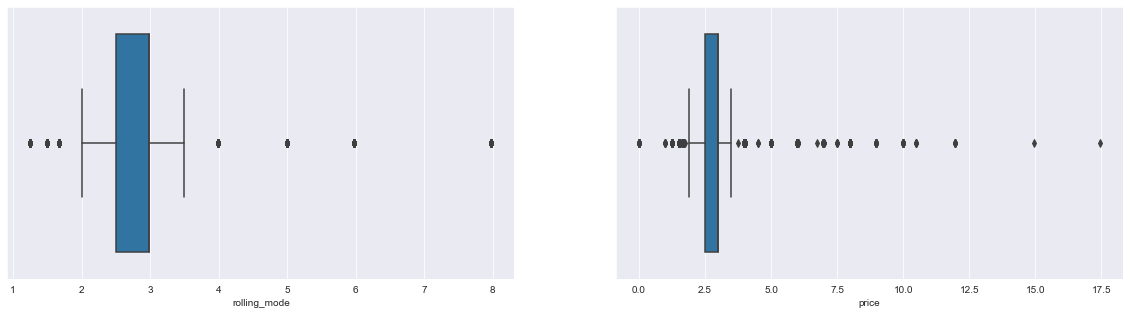

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20,5))
sns.boxplot(x=data.rolling_mode, ax=ax[0])
sns.boxplot(x=data.price, ax=ax[1])

plt.show()

#
Taking the mean price of each day is still to noisy. This can be smoothed by taking the mean or mode of a rolling 3 day period.

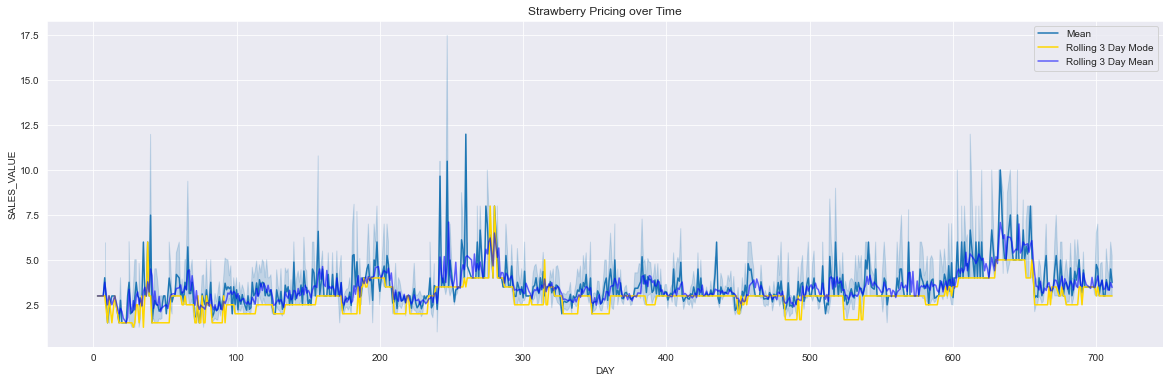

In [ ]:
fig, ax = plt.subplots(figsize=(20,6))

sns.lineplot(data=data_straw, x="DAY", y="SALES_VALUE")#, hue="CURR_SIZE_OF_PRODUCT", ax=ax)
sns.lineplot(data=mode_rolling, x="DAY", y="rolling_mode", ax=ax, color='gold')
sns.lineplot(data=mean_rolling, x="DAY", y="rolling_mean", ax=ax, alpha=0.6, color='blue')

plt.legend(['Mean', 'Rolling 3 Day Mode', 'Rolling 3 Day Mean'])

plt.title('Strawberry Pricing over Time')
plt.show()

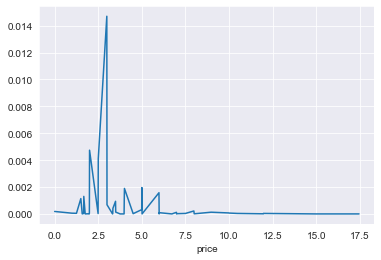

In [ ]:
(data.groupby('price')['purchased'].sum()/len(data)).plot()
plt.show()

<AxesSubplot:xlabel='price', ylabel='purchased'>

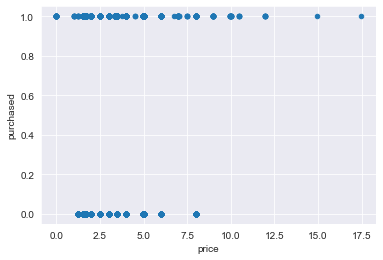

In [ ]:
data.plot(x='price', y='purchased', kind='scatter')

#
Use SMOTE to balance training data and lightBGM to model demand as a function of price. 

In [ ]:
X = data.copy()
X = X.drop(['rolling_mode', 'DAY'], axis=1)

# encode categorical features as integers
from sklearn import preprocessing
categorical_feature = []
for f in X.columns:
    if X[f].dtype=='object':
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(X[f].values))
        X[f] = lbl.transform(list(X[f].values))
        categorical_feature.append(f)

# drop features with low variance
from sklearn.feature_selection import VarianceThreshold
selector = VarianceThreshold()
X = selector.fit_transform(X)

# wrap in dataframe
X = pd.DataFrame(X)
X.columns = data.drop(['rolling_mode', 'DAY'], axis=1).columns[selector.get_support()]

X_orig = X.copy()

# downsample balance
# X = pd.concat([
#     X[X.purchased == 0].sample(n=sum(data.purchased == 1), random_state=2),
#     X[X.purchased == 1]
# ], axis=0)

y = X['purchased']
X = X.drop('purchased', axis=1)

X.head()

,MANUFACTURER,DEPARTMENT,COMMODITY_DESC,price,AGE_DESC,MARITAL_STATUS_CODE,INCOME_DESC,HOMEOWNER_DESC,HH_COMP_DESC,HOUSEHOLD_SIZE_DESC,KID_CATEGORY_DESC
0,0.0,1.0,0.0,2.50,3.0,2.0,0.0,4.0,3.0,0.0,3.0
1,4.0,1.0,0.0,2.00,3.0,2.0,0.0,4.0,3.0,0.0,3.0
2,4.0,1.0,0.0,2.00,3.0,2.0,0.0,4.0,3.0,0.0,3.0
3,4.0,1.0,0.0,2.99,3.0,2.0,0.0,4.0,3.0,0.0,3.0
4,4.0,1.0,0.0,2.99,3.0,2.0,0.0,4.0,3.0,0.0,3.0


In [ ]:
print(os.getcwd())
pd.concat([X, y], axis=1).to_csv('cleaned_strawberry_dataset.csv', index=False)

C:\Users\mlentini\OneDrive - Edmund Optics, Inc\Documents\Rowan\Thesis\Notebooks\student_prescription_tree


In [ ]:
num_round = 50 # number of boosting rounds as used in Biggs
param = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': '',
    'learning_rate': 0.1,
    'feature_fraction': 1.0,
    'bagging_fraction': 1.0,
    'bagging_freq': 0,
    'verbose': 1,
    'max_depth': -1
}

cats = np.where(X.columns.isin([x for x in X.columns if x not in ['price', 'INCOME_DESC']]))[0]
model = lgb.LGBMClassifier(n_estimators=num_round)#, categorical_feature=cats)#np.arange(len(X.columns)))#np.where(X.columns.isin(categorical_feature))[0])

from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=49, stratify=y)

# fix imbalance over training set only
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
#X_train, y_train = sm.fit_resample(X_train, y_train)

model.fit(X_train, y_train)

LGBMClassifier(n_estimators=50)

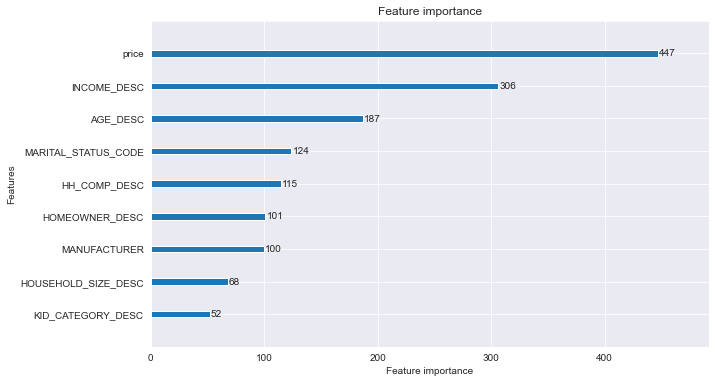

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))
lgb.plot_importance(model, ax=ax)
plt.show()

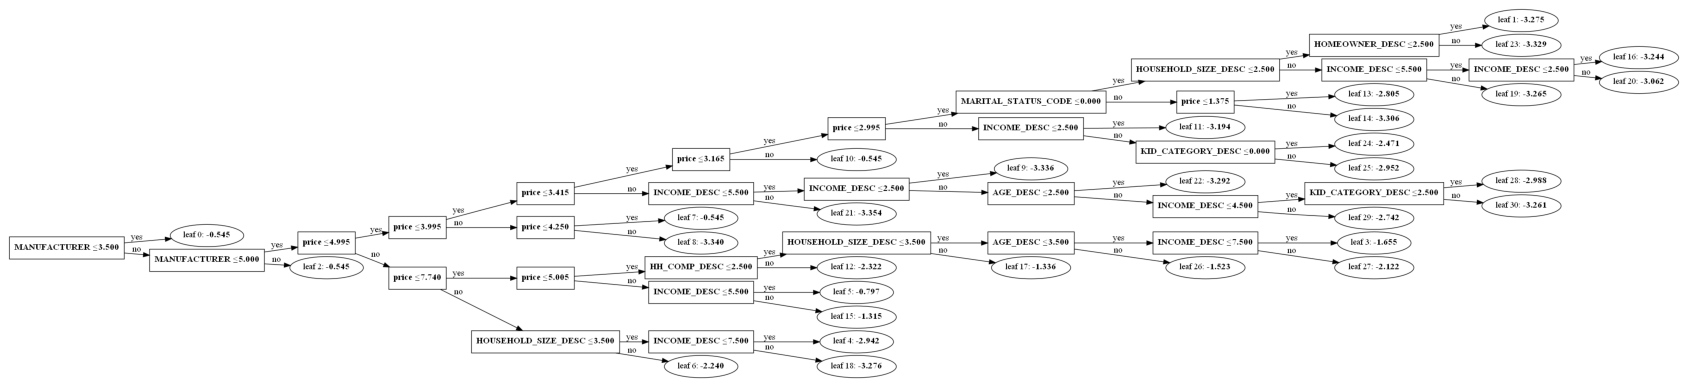

In [ ]:
gig, ax = plt.subplots(figsize=(30,8))
lgb.plot_tree(model, ax=ax)
plt.savefig('tree_plot.png')

plt.show()

#
Get counterfactual total expected revenue as a function of price

In [ ]:
def counterfactual(X_train, X_test):
    #Biggs et al, 2020 uses 10th and 90th percentile prices in 10% increments
    low_price = X_train.price.quantile(0.05)
    high_price = X_train.price.quantile(0.95)

    print('low price:', low_price)
    print('high price:', high_price)

    prices = np.linspace(low_price, high_price, 11)
    prices = np.linspace(1.99, 4.99, 7)
    revenue = []
    avg_purchase_prob = []
    for price in prices:
        counterfactual = X_test.copy()
        counterfactual.price = price
        purchase_prob = model.predict_proba(counterfactual)[:, 1]
        revenue.append(np.mean(price*purchase_prob))
        avg_purchase_prob.append(np.mean(purchase_prob))

    optimal_price = prices[np.where(revenue == np.max(revenue))][0]
    
    # join to original dataset before balanceing
#     X_train_, X_test_, y_train_, y_test_ = train_test_split(X, y, test_size=0.5, random_state=49)
#     X_train_[X_train_.index.isin(counterfactual.index)]
    
    return avg_purchase_prob, revenue, optimal_price, prices

low price: 1.67
high price: 3.99
Optimal price 2.99
Maximum Average Revenue: 0.107


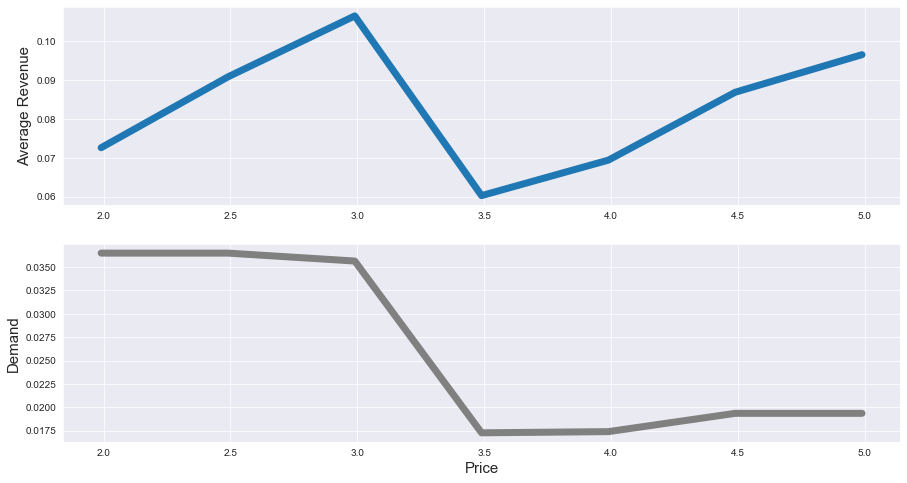

In [ ]:
X_train_, X_test_, y_train_, y_test_ = train_test_split(X, y, test_size=0.5, random_state=49)
avg_purchase_prob, revenue, optimal_price, prices = counterfactual(X_train, X_test)

#avg_purchase_prob = avg_purchase_prob[::-1]
#revenue = prices*avg_purchase_prob

fig, ax = plt.subplots(2, 1, figsize=(15,8))
ax[0].plot(prices, revenue, linewidth=7.0)
ax[0].set_ylabel('Average Revenue', fontsize=15)
ax[0].set_xlabel('')

ax[1].plot(prices, avg_purchase_prob, linewidth=7.0, color='grey')
ax[1].set_ylabel('Demand', fontsize=15)
ax[1].set_xlabel('Price', fontsize=15)

print('Optimal price', optimal_price)
print('Maximum Average Revenue:', np.max(revenue).round(3))
plt.show()

In [ ]:
# model out-of-sample score
print('In-sample error:', model.score(X_test, y_test))
print('Out-of-sample score:', model.score(X_test, y_test))

In-sample error: 0.9740900566267912
Out-of-sample score: 0.9740900566267912


#
Out-of-sample AUC performed the same as Biggs et al., 2021. We both measured 0.79. Is is unclear whether Biggs et al., balanced the dataset, and if they did which technique was used.

In [ ]:
# out-of-sample scores
from sklearn.metrics import accuracy_score, auc, roc_curve, precision_recall_curve, roc_auc_score, precision_score, recall_score, average_precision_score
def evaluate(model, testing_set_x, testing_set_y):
    predictions = model.predict_proba(testing_set_x)
    
    accuracy  = accuracy_score(testing_set_y, predictions[:,1] >= 0.5)
    roc_auc   = roc_auc_score(testing_set_y, predictions[:,1])
    precision = precision_score(testing_set_y, predictions[:,1] >= 0.5)
    recall    = recall_score(testing_set_y, predictions[:,1] >= 0.5)
    pr_auc    = average_precision_score(testing_set_y, predictions[:,1])
    
    result = pd.DataFrame([[accuracy, precision, recall, roc_auc, pr_auc]], columns=['Accuracy', 'Precision', 'Recall', 'ROC_auc','PR_auc'])
    return(result)

evaluate(model, X_test, y_test)

,Accuracy,Precision,Recall,ROC_auc,PR_auc
0,0.973726,0.923304,0.310362,0.816968,0.453001


#
Experiment with how the demand curve changes for different income buckets

In [ ]:
np.concatenate([data.INCOME_DESC.unique().reshape(-1,1), X.INCOME_DESC.unique().astype(int).reshape(-1,1)], axis=1)

array([['100-124K', 0],
       ['75-99K', 10],
       ['Under 15K', 11],
       ['125-149K', 1],
       ['50-74K', 9],
       ['150-174K', 3],
       ['35-49K', 8],
       ['25-34K', 6],
       ['250K+', 7],
       ['200-249K', 5],
       ['15-24K', 2],
       ['175-199K', 4]], dtype=object)

low price: 1.67
high price: 3.99
low price: 1.67
high price: 3.99
Optimal price 2.99
Maximum Average Revenue: 0.184


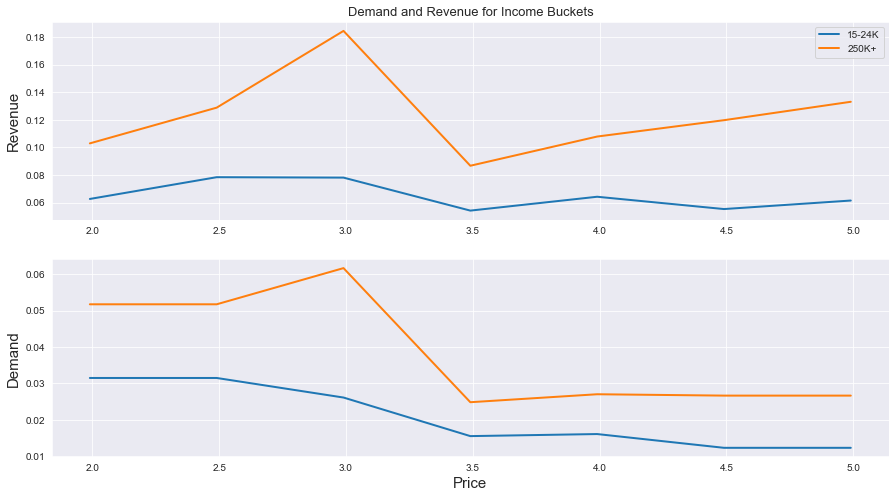

In [ ]:
# plot '15-24K'
income_bucket = 2
avg_purchase_prob, revenue, optimal_price, prices = counterfactual(X_train, X_test[X_test.INCOME_DESC == income_bucket])

fig, ax = plt.subplots(2, 1, figsize=(15,8))
ax[0].plot(prices, revenue, linewidth=2.0)
ax[0].set_ylabel('Revenue', fontsize=15)
ax[0].set_xlabel('')

ax[1].plot(prices, avg_purchase_prob, linewidth=2.0)#, color='grey')
ax[1].set_ylabel('Demand', fontsize=15)
ax[1].set_xlabel('Price', fontsize=15)

# plot '250K+' for comparison
income_bucket = 7
avg_purchase_prob, revenue, optimal_price, prices = counterfactual(X_train, X_test[X_test.INCOME_DESC == income_bucket])
ax[0].plot(prices, revenue, linewidth=2.0)
ax[1].plot(prices, avg_purchase_prob, linewidth=2.0)#, color='grey')

# add legends
ax[0].set_title('Demand and Revenue for Income Buckets', fontsize=13)
ax[0].legend(['15-24K', '250K+'])

print('Optimal price', optimal_price)
print('Maximum Average Revenue:', np.max(revenue).round(3))
plt.show()

# 
Plot average revenue by tree depth from SPT

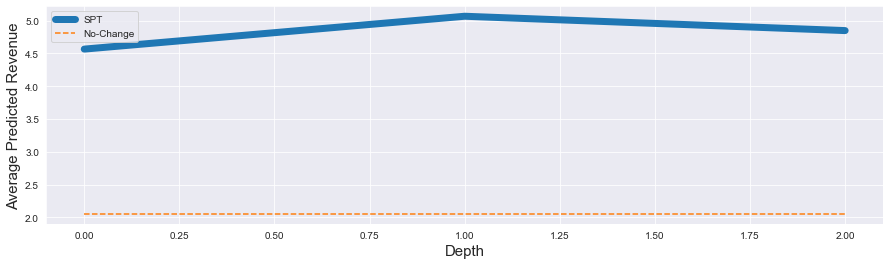

In [ ]:
results = [4.566902048915882, 5.067907694500349, 4.849184747578931]
f = 1
results = np.array(results)/f
fig, ax = plt.subplots(figsize=(15,4))
ax.plot(np.arange(0,3), results, linewidth=7.0)
ax.plot(np.arange(0,3), np.array(3*[2.0541071833989872])/f, '--')
ax.set_ylabel('Average Predicted Revenue', fontsize=15)
ax.set_xlabel('Depth', fontsize=15)

ax.legend(['SPT', 'No-Change'])
plt.show()

# Synthetic Datasets
#### Biggs et al. (2020)

Linear probit model:

$$Y^* = G(X) + h(X)P + \epsilon$$

Y = 1 if Y^* > = 0 and Y= 0 otherwise. We let $(X_0, X_1) \sim N(0,I_2), P \sim N(X_0+5,2), \epsilon \sim N(0,1)$ unless otherwise mentioned.

Dataset 1: linear probit model with no confounding: $G(X) = X_0, h(X) = -1, X \sim N(5, I_2)$ and $P \sim N(5,1)$

Dataset 5: linear probit model with observed confounding: $G(X) = X_0, h(X) = -1$

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('darkgrid')

In [ ]:
# sample size
n = 10000

# Dataset 1
Dataset 1: linear probit model with no confounding

Optimal Average Revenue: 5.010054795761414


,X0,X1,price,optimal_price,Y
0,6.187561,5.891018,5.308594,6.265517,1
1,4.091154,5.166375,5.347986,6.275970,1
2,4.341445,7.073474,4.730779,3.351629,0
3,4.336196,4.930243,3.557622,5.293032,1
4,6.121887,6.321753,5.777493,5.031515,0


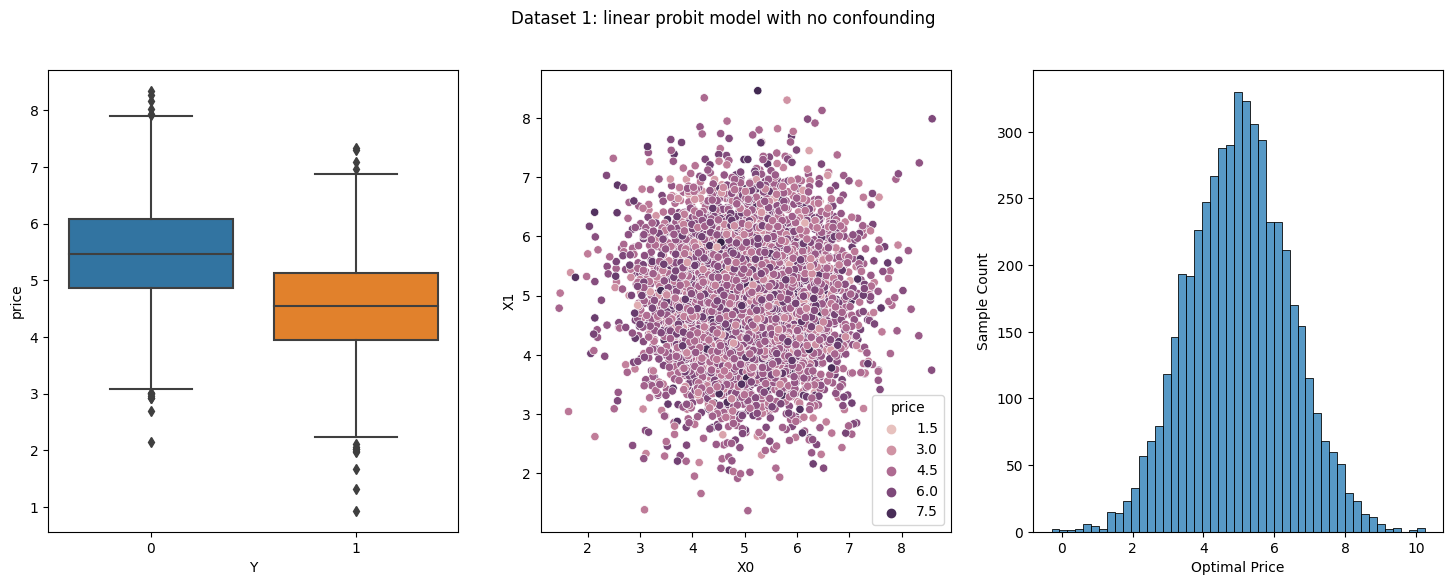

In [4]:
def model_1(n_samples):
    # dataset 1: linear probit model with no confounding
    # np.random.seed(101)
    def generate_model_1():
        h = -1
        n = 2
        I2 = np.identity(n)
        X = np.random.multivariate_normal([5, 5], I2)
        X0 = X[0]
        X1 = X[1]
        P = np.random.normal(5, 1)
        epsilon = np.random.normal(0, 1)
            
        # compute optimal price
        g = X0
        optimal_price = -(g + epsilon)/h

        Y_star = g + h*P + epsilon 

        return X0, X1, P, Y_star, optimal_price

    results = {
        'X0':[],
        'X1':[],
        'price':[],
        'optimal_price':[],
        'Y':[]
        }

    for i in range(n_samples):
        X0, X1, P, Y_star, optimal_price = generate_model_1()
        results['X0'].append(X0)
        results['X1'].append(X1)
        results['price'].append(P)
        results['optimal_price'].append(optimal_price)
        results['Y'].append(int(Y_star > 0))

    results = pd.DataFrame(results)

    # get header
    # results['dataset'] = 1
    return results
    
# visualize results
results = model_1(n_samples=5000)

# set model params
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 16}

import matplotlib
# matplotlib.rc('font', **font)
matplotlib.rcdefaults()

fig, ax = plt.subplots(1, 3, figsize=(18, 6))
sns.boxplot(data=results, x='Y', y='price', ax = ax[0])
sns.scatterplot(data=results, x='X0', y='X1', hue='price', ax=ax[1])
sns.histplot(data=results, x='optimal_price', ax=ax[2])
plt.suptitle("Dataset 1: linear probit model with no confounding")
 

ax[2].set_ylabel("Sample Count")
ax[2].set_xlabel("Optimal Price")
print('Optimal Average Revenue:', results.optimal_price.sum()/len(results))
results.head()

# Dataset 2
Dataset 2: higher dimension probit model with sparse linear interaction, where purchase probability is only dependent on the first 5 features.

In [ ]:
def model_2(n_samples):
    # dataset 2
    np.random.seed(101)
    def generate_model_2():
        g = 5
        X_prime = np.random.multivariate_normal([0]*20, np.identity(20))

        # draw beta 1 through 5
        beta_5 = np.random.multivariate_normal([0]*5, np.identity(5))
        beta_20 = [0]*15
        beta = np.concatenate([beta_5, beta_20])

        # take linear combo to get h(X)
        h = -1.5*(X_prime*beta).sum()

        # draw prices and noise
        P = np.random.normal(0, 2)
        epsilon = np.random.normal(0, 1)
        
        # compute optimal price
        optimal_price = -1*(g + epsilon)/h

        # compute Y*
        Y_star = g + h*P + epsilon 

        return X_prime, P, Y_star, optimal_price

    cols = ['X' + str(i) for i in range(20)] + ['price', 'optimal_price', 'Y']
    results = pd.DataFrame(columns=cols)

    for i in range(n_samples):
        X_prime, P, Y_star, optimal_price = generate_model_2()
        x = X_prime.tolist() + [P, optimal_price, int(Y_star > 0)]

        results.loc[i] = x

    return results
        
# visualize results
# results = model_2()

# fig, ax = plt.subplots(2)
# sns.boxplot(data=results, x='Y', y='price', ax = ax[0])
# sns.histplot(data=results, x='optimal_price', ax=ax[1])
 
# print('Optimal Average Revenue:', results.optimal_price.sum()/len(results))
    
# results.head()

# Dataset 3
Dataset 3: probit model with step interaction

,X0,X1,price,Y,optimal_price
0,2.706850,0.628133,9.522789,0,6.879782
1,0.651118,-0.319318,3.954964,0,6.228850
2,-2.018168,0.740122,4.039459,0,3.675833
3,0.188695,-0.758872,3.322221,0,6.616729
4,0.190794,1.978757,10.402729,0,6.315010


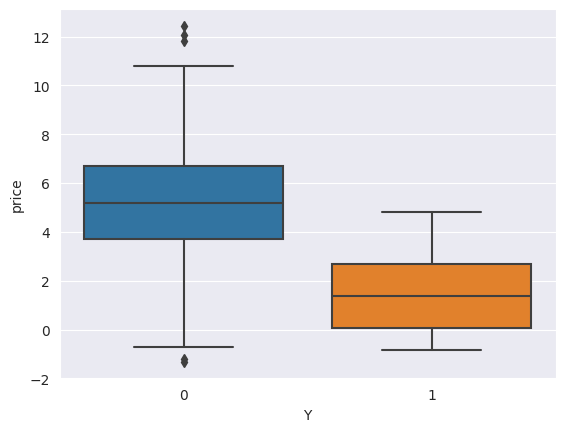

In [ ]:
def model_3(n_samples):
    # dataset 2
    np.random.seed(101)
    def generate_model_3():
        g = 5
        
        # first draw X0 and X1:
        n = 2
        I2 = np.identity(n)
        X = np.random.multivariate_normal([0, 0], I2)
        X0 = X[0]
        X1 = X[1]

        # next find piecewise-constant step function h
        if X0 < -1:
            h = -1.2
        elif -1 <= X0 < 0:
            h = -1.1
        elif 0 <= X0 < 1:
            h = -0.9
        elif 1 <= X0:
            h = -0.8

        # draw prices and noise
        P = np.random.normal(X0 + 5, 2)
        epsilon = np.random.normal(0, 1)

        # compute Y*
        Y_star = X0 + h*P + epsilon 

        # compute optimal price
        optimal_price = -1*(g + epsilon)/h

        return X0, X1, P, Y_star, optimal_price

    results = {
        'X0':[],
        'X1':[],
        'price':[],
        'Y':[],
        'optimal_price':[]
        }

    for i in range(n_samples):
        X0, X1, P, Y_star, optimal_price = generate_model_3()
        results['X0'].append(X0)
        results['X1'].append(X1)
        results['price'].append(P)
        results['Y'].append(int(Y_star > 0))
        results['optimal_price'].append(optimal_price)

    results = pd.DataFrame(results)

    return results
    
# visualize results
results = model_3(1000)
sns.boxplot(data=results, x='Y', y='price')
    
results.head()

# Dataset 4

Optimal Avg. Revenue: 5.222223210058946


,X0,X1,price,Y,optimal_price,user_feature
0,-0.993348,1.110086,2.462363,1,6.000085,1
1,0.105566,1.247823,5.215515,0,4.601368,1
2,0.015390,0.241389,4.413096,1,7.626928,1
3,1.904667,-3.870439,4.585159,1,5.453807,0
4,1.379418,0.724418,6.998563,0,6.698171,1


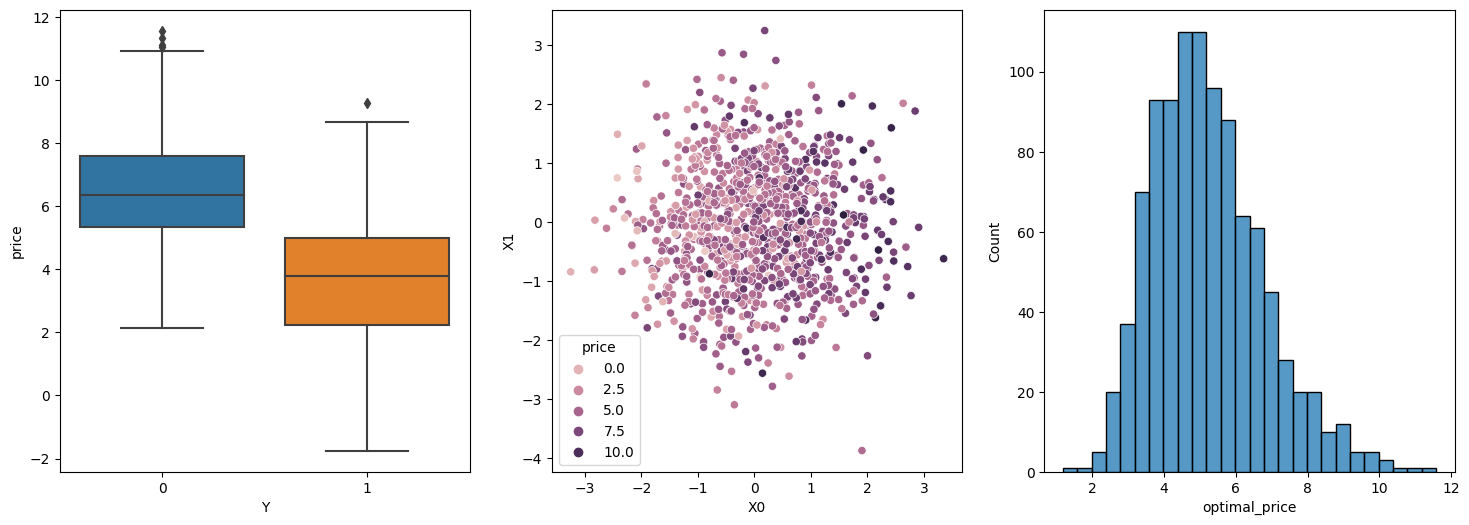

In [ ]:
def model_4(n_samples): 
    # dataset 2
    # np.random.seed(101)
    def generate_model_4():
        g = 5

        # first draw X0 and X1:
        n = 2
        I2 = np.identity(n)
        X = np.random.multivariate_normal([0, 0], I2)
        X0 = X[0]
        X1 = X[1]

        # next find piecewise-constant step function h
        # X1 influence price sensitivity, must be a 
        # consumer attribute
        h = -1.25 * int(X0 < -1) + \
          -1.1 * int(-1 <= X0 < 0) + \
          -0.9 * int(0 <= X0 < 1) + \
          -0.75 * int(1 <= X0) + \
          -0.1 * int(X1 < 0) + \
          0.1 * int(X1 >= 0)            # less sensitive to price

        # draw prices and noise
        # price depends on X0, so must be 
        # a product attribute
        P = np.random.normal(X0 + 5, 2)
        epsilon = np.random.normal(0, 1)

        # compute Y*
        Y_star = g + h*P + epsilon 

        optimal_price = -1*(g + epsilon)/h

        return X0, X1, P, Y_star, optimal_price

    results = {
        'X0':[],
        'X1':[],
        'price':[],
        'Y':[],
        'optimal_price':[]
              }

    for i in range(n_samples):
        X0, X1, P, Y_star, optimal_price = generate_model_4()
        results['X0'].append(X0)
        results['X1'].append(X1)
        results['price'].append(P)
        results['Y'].append(int(Y_star > 0))
        results['optimal_price'].append(optimal_price)

    results = pd.DataFrame(results)
    
    return results

# visualize results
results = model_4(n_samples=1000)

results['user_feature'] = (results.X1 > 0).astype(int)

fig, ax = plt.subplots(1, 3, figsize=(18, 6))
sns.boxplot(data=results, x='Y', y='price', ax = ax[0])
sns.scatterplot(data=results, x='X0', y='X1', hue='price', ax=ax[1])
sns.histplot(data=results, x='optimal_price', ax=ax[2])

print('Optimal Avg. Revenue:', results.optimal_price.sum() / len(results))
results.head()

In [ ]:
# chi2 independence test
from scipy.stats import chi2_contingency
cont_table = pd.crosstab(index=results.Y, columns=(results.X1 > 0).astype(int))

res = chi2_contingency(cont_table)
if res.pvalue < 0.01:
  print('Probability of purchase Y and user feature X1 > 0 are not independent.')
else:
  print('Probability of purchase Y and user feature X1 > 0 are independent.')


Probability of purchase Y and user feature X1 > 0 are not independent.


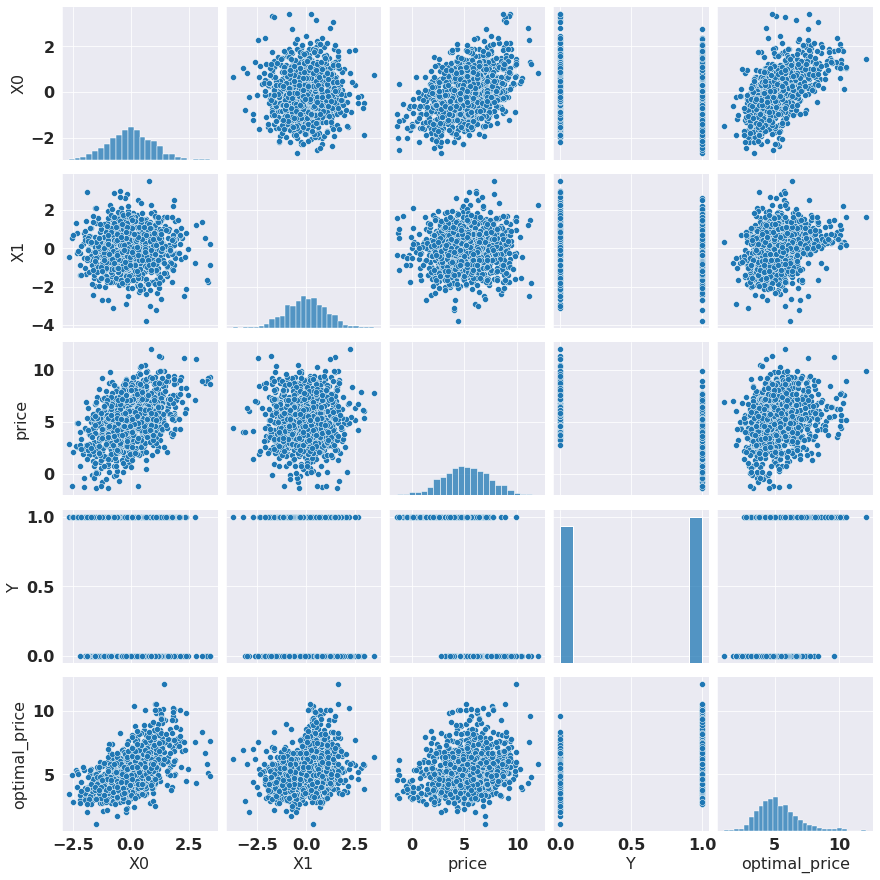

In [ ]:
# make pairplot
sns.pairplot(data=results)
plt.show()

# Dataset 5
Dataset 5: linear probit model with observed confounding. The confounder is the dependence of price on covariates.

Optimal Average Revenue: 0.030256463485745975


,X0,X1,price,Y,optimal_price
0,2.706850,0.628133,9.522789,0,3.210676
1,0.651118,-0.319318,3.954964,0,1.257083
2,-2.018168,0.740122,4.039459,0,-2.607169
3,0.188695,-0.758872,3.322221,0,1.143752
4,0.190794,1.978757,10.402729,0,0.874303


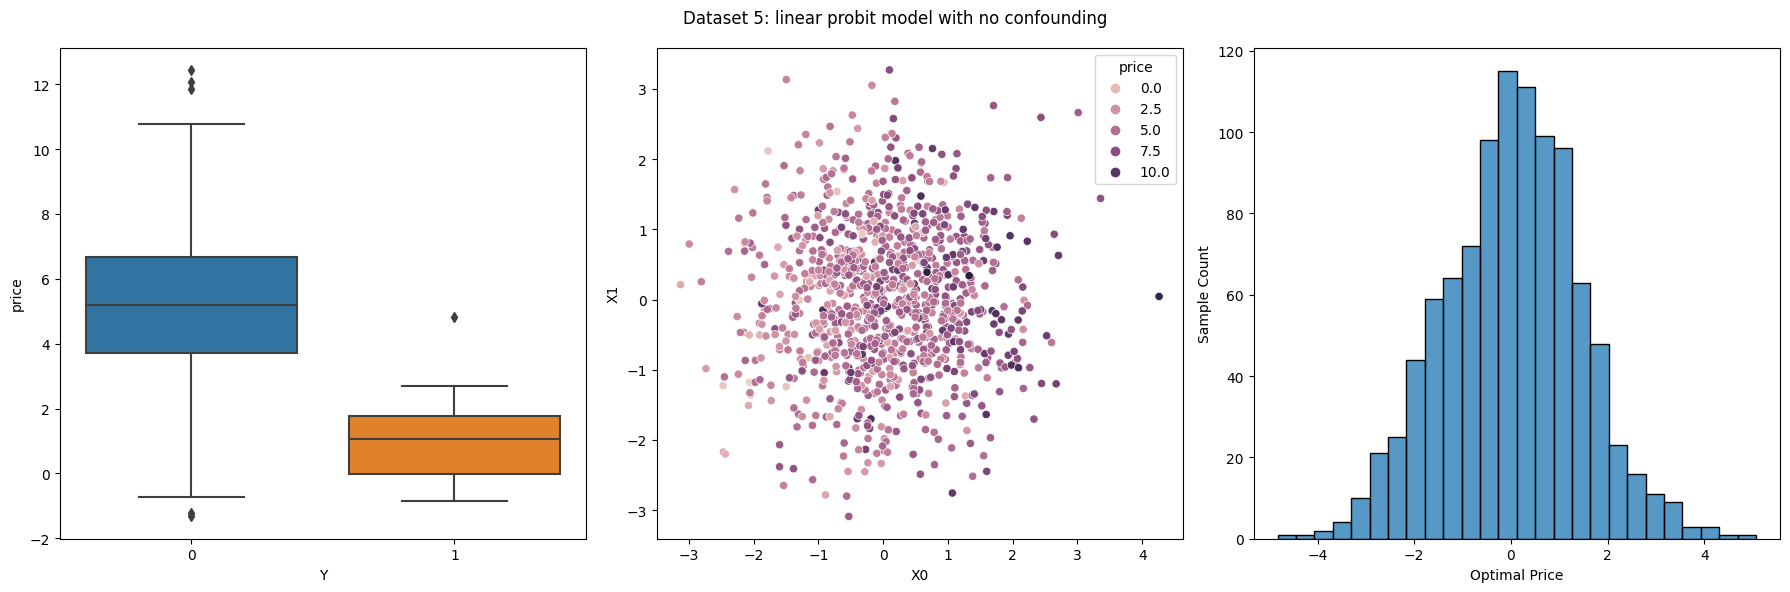

In [ ]:
def model_5(n_samples):
    # dataset 2: linear probit model with no confounding
    np.random.seed(101)
    def generate_model_5():
        h = -1
        n = 2
        I2 = np.identity(n)
        X = np.random.multivariate_normal([0, 0], I2)
        X0 = X[0]
        X1 = X[1]
        P = np.random.normal(X0 + 5, 2)
        epsilon = np.random.normal(0, 1)

        Y_star = X0 + h*P + epsilon 

        optimal_price = -1*(X0 + epsilon)/h

        return X0, X1, P, Y_star, optimal_price

    results = {
        'X0':[],
        'X1':[],
        'price':[],
        'Y':[],
        'optimal_price':[]
              }

    for i in range(n_samples):
        X0, X1, P, Y_star, optimal_price = generate_model_5()
        results['X0'].append(X0)
        results['X1'].append(X1)
        results['price'].append(P)
        results['Y'].append(int(Y_star > 0))
        results['optimal_price'].append(optimal_price)

    results = pd.DataFrame(results)
    # results['dataset'] = 6
    return results 

# visualize results
results = model_5(n_samples=1000)

# make figure
fig, ax = plt.subplots(1, 3, figsize=(18, 6))

sns.boxplot(data=results, x='Y', y='price', ax = ax[0])
sns.scatterplot(data=results, x='X0', y='X1', hue='price', ax=ax[1])
sns.histplot(data=results, x='optimal_price', ax=ax[2])
plt.suptitle("Dataset 5: linear probit model with no confounding")
 
ax[2].set_ylabel("Sample Count")
ax[2].set_xlabel("Optimal Price")
print('Optimal Average Revenue:', results.optimal_price.sum()/len(results))
    
plt.tight_layout()
# plt.savefig('figures/dataset5_sample.png')
results.head()

# Dataset 6
Dataset 6: probit model with non-linear interaction

,X0,X1,price,Y,optimal_price,dataset
0,2.706850,0.628133,9.522789,0,4.151073,6
1,0.651118,-0.319318,3.954964,0,5.826298,6
2,-2.018168,0.740122,4.039459,0,3.539140,6
3,0.188695,-0.758872,3.322221,0,5.675018,6
4,0.190794,1.978757,10.402729,0,4.315046,6


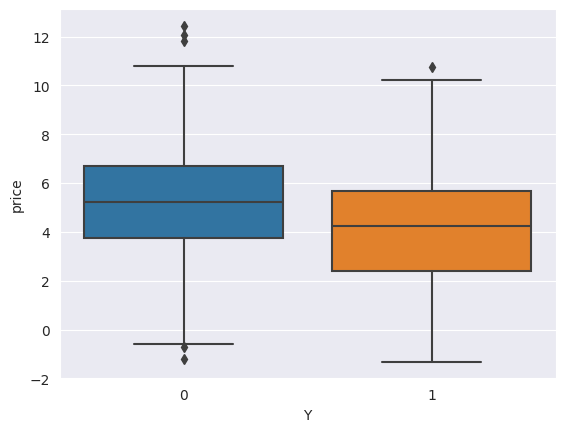

In [ ]:
def model_6(n_samples):
    # dataset 2: linear probit model with no confounding
    np.random.seed(101)
    def generate_model_6():
        # first draw X0 and X1:
        I2 = np.identity(2)
        X = np.random.multivariate_normal([0, 0], I2)
        X0 = X[0]
        X1 = X[1]

        # compute intercept and slope
        g = 4*np.abs(X0 + X1)
        h = -1*np.abs(X0 + X1)

        # draw price and noise
        P = np.random.normal(X0 + 5, 2)
        epsilon = np.random.normal(0, 1)

        # compute Y*
        Y_star = X0 + h*P + epsilon 

        # optimal price
        optimal_price = -1*(g + epsilon)/h

        return X0, X1, P, Y_star, optimal_price

    results = {
        'X0':[],
        'X1':[],
        'price':[],
        'Y':[],
        'optimal_price':[]
              }

    for i in range(n_samples):
        X0, X1, P, Y_star, optimal_price = generate_model_6()
        results['X0'].append(X0)
        results['X1'].append(X1)
        results['price'].append(P)
        results['Y'].append(int(Y_star > 0))
        results['optimal_price'].append(optimal_price)

    results = pd.DataFrame(results)

    # get header
    results['dataset'] = 6
    return results
    
# visualize results
results = model_6(1000)
sns.boxplot(data=results, x='Y', y='price')

results.head()

In [ ]:
# save datasets into one csv file
# sample size
n = 10000
synthetic_data = pd.DataFrame()

# loop through models and append to empty df
models = [model_1(), model_2(), model_3(), model_4(), model_5(), model_6()]
for model in models:
    synthetic_data = pd.concat([synthetic_data, model])
    
synthetic_data.to_csv('synthetic_datasets.csv')
print(len(synthetic_data))
synthetic_data.head()

60000


,X0,X1,price,Y,dataset
0,7.706850,5.628133,5.907969,1,1
1,5.651118,4.680682,4.151923,1,1
2,2.981832,5.740122,5.528813,0,1
3,5.188695,4.241128,4.066763,1,1
4,5.190794,6.978757,7.605967,0,1


# Train lightGBM on Synthetic Data
Use default parameters with 50 boosting rounds

In [5]:
import lightgbm as lgb

def use_model(model_id, n_samples):
    if model_id == 1:
        return model_1(n_samples)
    elif model_id == 2:
        return model_2(n_samples)
    elif model_id == 3:
        return model_3(n_samples)
    elif model_id == 4:
        return model_4(n_samples)
    elif model_id == 5:
        return model_5(n_samples)
    elif model_id == 6:
        return model_6(n_samples)

In [ ]:
# generate dataset 1
results = use_model(5)

# get data
covariates = [x for x in results.columns if x not in ['optimal_price', 'Y']]
print(covariates)
X = results[covariates]
y = results['Y']

# lightGBM
num_round = 50 
model = lgb.LGBMClassifier(n_estimators=num_round)

# split data in half
from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=49, stratify=y)

# fix imbalance over training set only
model.fit(X_train, y_train)

['X0', 'X1', 'price']


LGBMClassifier(n_estimators=50)

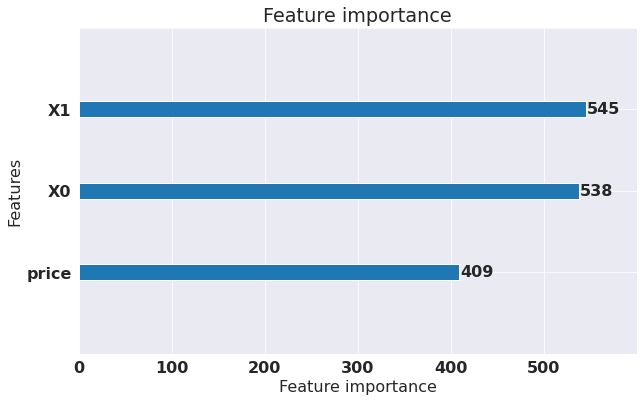

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))
lgb.plot_importance(model, ax=ax)
plt.show()

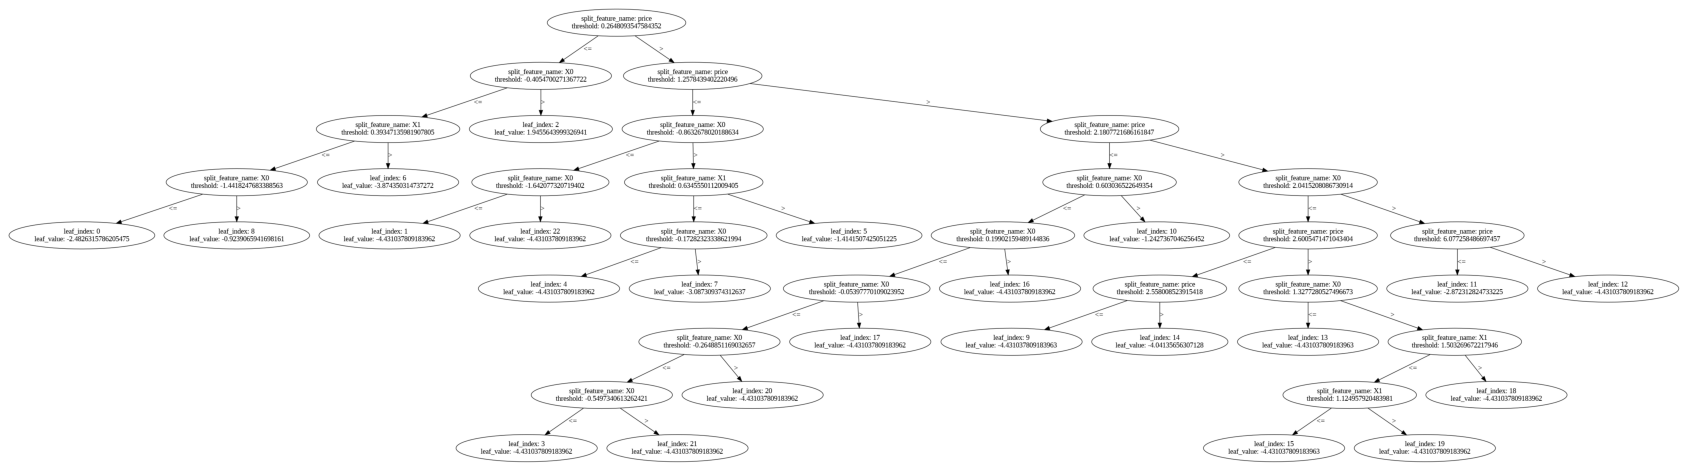

In [ ]:
gig, ax = plt.subplots(figsize=(30,15))
lgb.plot_tree(model, ax=ax)

plt.show()

In [ ]:
def counterfactual(X_train, X_test):
    #Biggs et al, 2020 uses 10th and 90th percentile prices in 10% increments
    low_price = X_train.price.quantile(0.10)
    high_price = X_train.price.quantile(0.90)

    print('low price:', low_price)
    print('high price:', high_price)

    prices = np.linspace(low_price, high_price, 11)
    revenue = []
    avg_purchase_prob = []
    for price in prices:
        counterfactual = X_test.copy()
        # give everyone the same global pricfe
        # no personalization
        counterfactual.price = price
        purchase_prob = model.predict_proba(counterfactual)[:, 1]
        revenue.append(np.mean(price*purchase_prob))
        avg_purchase_prob.append(np.mean(purchase_prob))

    optimal_price = prices[np.where(revenue == np.max(revenue))][0]
    
    return avg_purchase_prob, revenue, optimal_price, prices

low price: 2.1444102888303904
high price: 7.953788219340372
Optimal price 2.1444102888303904
Maximum Average Revenue: 0.225


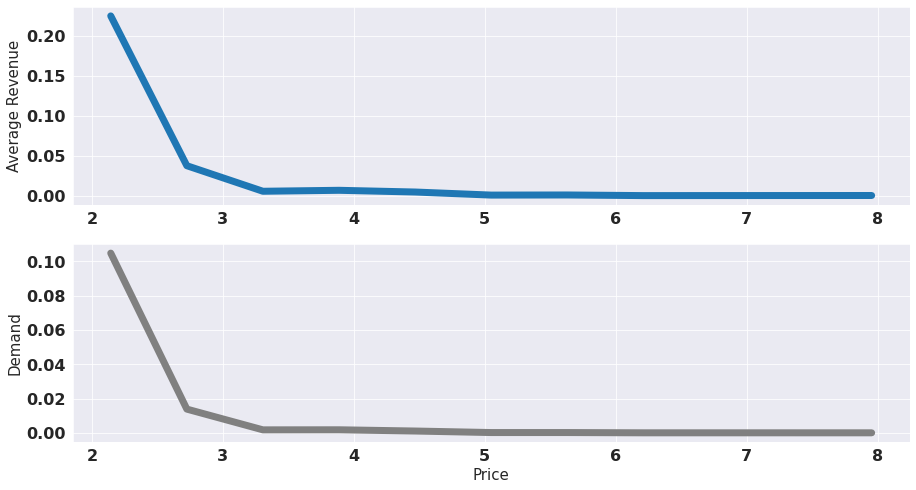

In [ ]:
# estimate demand
avg_purchase_prob, revenue, optimal_price, prices = counterfactual(X_train, X_test)

fig, ax = plt.subplots(2, 1, figsize=(15,8))
ax[0].plot(prices, revenue, linewidth=7.0)
ax[0].set_ylabel('Average Revenue', fontsize=15)
ax[0].set_xlabel('')

ax[1].plot(prices, avg_purchase_prob, linewidth=7.0, color='grey')
ax[1].set_ylabel('Demand', fontsize=15)
ax[1].set_xlabel('Price', fontsize=15)

print('Optimal price', optimal_price)
print('Maximum Average Revenue:', np.max(revenue).round(3))
plt.show()

# Model Distillation for Revenue Optimized Personalized Pricing

In [ ]:
# generate data
results = use_model(model_id=4, n_samples=5000)

# separate features and target
covariates = [x for x in results.columns if x not in ['optimal_price', 'Y']]
print(covariates)
X = results[covariates]
y = results['Y']

# train lightGBM
num_round = 50 
model = lgb.LGBMClassifier(n_estimators=num_round)

# split data in half
from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=49, stratify=y)

# fix imbalance over training set only
model.fit(X_train, y_train)

print(model.best_score_)

['X0', 'X1', 'price']
defaultdict(<class 'dict'>, {})


In [ ]:
def get_revenue_matrix(model, X_train):
  model.predict(X_train)

  # discretize prices
  low_price = X_train.price.quantile(0.10)
  high_price = X_train.price.quantile(0.90)

  print('low price:', low_price)
  print('high price:', high_price)

  prices = np.linspace(low_price, high_price, 9)

  # make empty response matrix
  revenue_matrix = np.empty((len(X_train), len(prices)))

  for i in range(len(prices)):
    counterfactual = X_train.copy()
    price = prices[i]
    counterfactual.price = price

    # construct reponse matrix
    revenue_matrix[:, i] = price * model.predict_proba(counterfactual)[:, 1]

  return revenue_matrix

low price: 2.009925077120855
high price: 7.805762803751881
Optimized Revenue: 9341.532486941673
Actual Revenue: 4796.362614264117
9
2
7905.693209548415


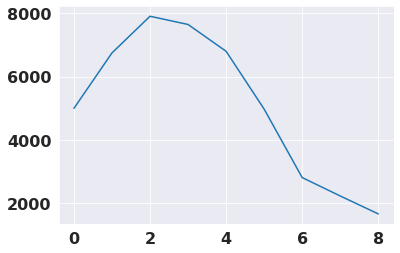

In [ ]:
# get response matrix
revenue_matrix = get_revenue_matrix(model, X_train)

# calculate optimal revenue for dataset
print(
    "Optimized Revenue:",
    revenue_matrix.max(axis=1).sum()
)

print(
    "Actual Revenue:",
    (X_train['price'] * y_train).sum()
)

rev_at_price = revenue_matrix[:, :].sum(axis=0)
print(len(rev_at_price))
print(np.argmax(rev_at_price))
print(np.max(rev_at_price))
plt.plot(rev_at_price)
plt.show()

In [ ]:
# create root node
root_node = dict(
    datapoints=np.arange(len(X_train)), 
    depth=0,
    left_child=None,
    right_child=None,
    revenue=None
)

print(root_node)

# intialize tree
tree = [root_node]

# set max depth stopping criteria
max_depth = 3

# intitialize list to collect leave nodes
leaf_nodes = []

def split(parent):
  """
  S: positional indices of set
  """
  # initialize right and left children
  depth = parent['depth'] + 1
  left_child = dict(datapoints=None, depth=depth)
  right_child = dict(datapoints=None, depth=depth)

  # get parent node datapoints indices
  S = parent['datapoints']

  # get corresponding data
  X = X_train.drop('price', axis=1).to_numpy()[S, :]
  n_observations, n_features = X.shape

  # search every single feature 
  # and every single observation
  # for the optimal split
  best_split_revenue = 0
  for i in range(n_observations):
    for j in range(n_features):
      # get children sets
      S1 = np.flatnonzero(X[:, j] <= X[i, j])
      S2 = np.flatnonzero(X[:, j] > X[i, j])
      # calculate total revenue
      R1 = revenue_matrix[S1, j].sum()
      R2 = revenue_matrix[S2, j].sum()
      # if set is empty associated revenue 
      # is defined as 0
      total_revenue = np.nan_to_num(R1, 0) + np.nan_to_num(R2, 0)
  
      if total_revenue > best_split_revenue:
        # update best split
        parent['split_value'] = X[i, j]
        parent['split_feature'] = j

        # update chidlren datapoints
        left_child['datapoints'] = S1
        right_child['datapoints'] = S2

        # add optimal revenue
        left_child['revenue'] = R1
        right_child['revenue'] = R2

        # update optimal greedy split revenue
        best_split_revenue = total_revenue

  # update parent children
  parent['left_child'] = left_child
  parent['right_child'] = right_child

  if depth < max_depth:
    # recursively iterate
    split(left_child)
    split(right_child)

  else:
    leaf_nodes.append(left_child)
    leaf_nodes.append(right_child)

{'datapoints': array([   0,    1,    2, ..., 2497, 2498, 2499]), 'depth': 0, 'left_child': None, 'right_child': None, 'revenue': None}


In [ ]:
split(root_node)

In [ ]:
# get personalized pricing revenue
sum([leaf_node['revenue'] for leaf_node in leaf_nodes])

7768.505403886294

In [ ]:
S = np.arange(len(X_train))
X = X_train.drop('price', axis=1).to_numpy()[S, :]
print(X_train.shape)
print(X.shape)

i = 1
j = 1
S1 = np.flatnonzero(X[:, j] <= X[i, j])
S2 = np.flatnonzero(X[:, j] > X[i, j])

set(S1.tolist() + S2.tolist()) == set(S)

(5000, 3)
(5000, 2)


True

In [ ]:
if not None:
  print('Yes')

Yes


# Student Prescription Tree

In [ ]:
#from math import e
import warnings

class StudentPrescriptionTree():
  def __init__(self, teacher_model, max_depth):
    self.teacher_model = teacher_model
    self.max_depth = max_depth
    self.root_node = None
    self.prices = None
    self.train_size = None

  def get_revenue_matrix(self, X):
    # get descrete prices
    prices = self.prices

    # make empty response matrix
    revenue_matrix = np.empty((len(X), len(prices)))

    for i in range(len(prices)):
      counterfactual = X.copy()
      price = prices[i]
      counterfactual.price = price

      # construct reponse matrix
      revenue_matrix[:, i] = price * self.teacher_model.predict_proba(counterfactual)[:, 1]

    return revenue_matrix

  def discretize_prices_(self, X_train):
    # discretize prices
    low_price = X_train.price.quantile(0.10)
    high_price = X_train.price.quantile(0.90)

    self.prices = np.linspace(low_price, high_price, 9)

  def fit(self, X_train, revenue_matrix=None):
    self.train_size = len(X_train)

    # discretize prices
    self.discretize_prices_(X_train)

    # get revenue matrix for training data
    if revenue_matrix is None:
      revenue_matrix = self.get_revenue_matrix(X_train)

    # get best price index
    best_price = np.argmax(revenue_matrix.sum(axis=0))
    # get best revenue
    best_R = np.max(revenue_matrix.sum(axis=0))

    # create root node
    self.root_node = dict(
        datapoints=np.arange(len(X_train)), 
        depth=0,
        left_child=None,
        right_child=None,
        price=best_price,
        revenue=best_R
    )

    # intitialize list to collect leave nodes
    leaf_nodes = []

    def split(parent):
      """
      Split parent node into binary children
      """
      # initialize right and left children
      depth = parent['depth'] + 1
      left_child = dict(
          datapoints=[], 
          depth=depth,
          left_child=None,
          right_child=None,
          children=False)
      right_child = dict(
          datapoints=[], 
          depth=depth,
          left_child=None,
          right_child=None,
          children=False)

      # get parent node datapoints indices
      S = parent['datapoints']

      # get corresponding data
      X = X_train.drop('price', axis=1).to_numpy()[S, :]
      n_observations, n_features = X.shape

      # search every single feature 
      # and every single observation
      # for the optimal split
      best_split_revenue = 0
      for i in range(n_observations):
        for j in range(n_features):
          # get children sets
          S1 = S[np.flatnonzero(X[:, j] <= X[i, j])]
          S2 = S[np.flatnonzero(X[:, j] > X[i, j])]
          # now that we've split the data
          # search for the best price-combo using
          # pre-calculated revenue matrix
          # get revenue at each price point
          R1 = revenue_matrix[S1, :].sum(axis=0)
          R2 = revenue_matrix[S2, :].sum(axis=0)

          # get best price index
          best_price1 = np.argmax(R1)
          best_price2 = np.argmax(R2)
          # get best revenue
          best_R1 = np.max(R1)
          best_R2 = np.max(R2)

          # if set is empty associated revenue 
          # is defined as 0
          total_revenue = np.nan_to_num(best_R1, 0) + np.nan_to_num(best_R2, 0)
    
          if total_revenue > best_split_revenue:
            # update best split
            parent['split_value'] = X[i, j]
            parent['split_feature'] = j

            # raise exception if partitioning is 
            # improperly performed
            if set(S1.tolist() + S2.tolist()) != set(S):
              raise Exception("Disallowed Split")

            # update children datapoints
            left_child['datapoints'] = S1
            right_child['datapoints'] = S2

            # update children best greedy price indices
            left_child['price'] = best_price1
            right_child['price'] = best_price2

            # update best greedy revenue
            left_child['revenue'] = best_R1
            right_child['revenue'] = best_R2

            # update optimal greedy split revenue
            best_split_revenue = total_revenue

      # check that revenue has not decreased
      if parent['revenue'] - best_split_revenue > 0.001:
        raise Exception("Disallowed revenue decrease.",
                        total_revenue, parent['revenue'])

      if depth < self.max_depth:
        a = len(left_child['datapoints']) > 0
        b = len(right_child['datapoints']) > 0
        if a & b:
          # update parent children
          parent['left_child'] = left_child
          parent['right_child'] = right_child

          # update children indicator
          parent['children'] = True

          # recursively iterate
          split(left_child)
          split(right_child)

    # recursively split training data
    split(self.root_node)

  def predict(self, X_test):
    """
    Build a second tree using test data
    and first tree
    """
    # copy root node
    root_node1 = self.root_node.copy()
    root_node2 = dict(
        datapoints=np.arange(len(X_test)), 
        depth=0,
        left_child=None,
        right_child=None,
        revenue=None
    )

    # get revenue matrix for test data
    revenue_matrix = self.get_revenue_matrix(X_test)

    # intitialize list to collect leave nodes
    leaf_nodes = []

    def split(parent1, parent2):
      """
      parent1: from train set
      parant2: from test set
      """
      # get children depth
      depth = parent1['depth'] + 1
      # get parent node datapoints indices
      S = parent2['datapoints']
      #if depth - 1 < self.max_depth:
      if parent1['children']:
        
        # get corresponding data
        X = X_test.drop('price', axis=1).to_numpy()[S, :]

        # split data
        j = parent1['split_feature']
        v = parent1['split_value']

        # get price assignment
        k1 = parent1['left_child']['price']
        k2 = parent1['right_child']['price']

        S1 = S[np.flatnonzero(X[:, j] <= v)]
        S2 = S[np.flatnonzero(X[:, j] > v)]

        # initialize right and left children
        left_child = dict(datapoints=[], depth=depth)
        right_child = dict(datapoints=[], depth=depth)

        # assign split datapoint
        left_child['datapoints'] = S1
        right_child['datapoints'] = S2

        # store best_price index
        left_child['price'] = k1
        right_child['price'] = k2

        # calculate total revenue
        left_child['revenue'] = revenue_matrix[S1, k1].sum()
        right_child['revenue'] = revenue_matrix[S2, k2].sum()

        # update parent children
        parent2['left_child'] = left_child
        parent2['right_child'] = right_child

        # recursively iterate
        split(parent1['left_child'], left_child)
        split(parent1['right_child'], right_child)

      else:
        leaf_nodes.append(parent2)  

    # call recursive split
    split(root_node1, root_node2)

    return leaf_nodes

  def predict_revenue(self, X_test):
    """
    Return average revenue per individual 
    from personalization
    """
    # get leave nodes
    leaf_nodes = self.predict(X_test)

    # get personalized pricing revenue
    rev = sum([leaf_node['revenue'] for leaf_node in leaf_nodes])   

    return rev / len(X_test)

  def get_optimal_revenue(self, X):
    """
    Return average revenue per individual 
    from optimal
    """
    # get revenue matrix for training data
    revenue_matrix = self.get_revenue_matrix(X)

    return revenue_matrix.max(axis=1).sum() / len(X)

  def get_nodes(self, depth=None):
    """
    depth: (int)
    Return a list of root nodes 
    corresponding to a depth.
    If depth is None then depth is 
    automatically set to max_depth
    """
    nodes = []
    if depth is None:
      depth = self.max_depth

    # start at root and go down
    # until depth is reach and
    # all corresponding nodes obtained
    def go_down(node):
      if node['depth'] == depth:
        nodes.append(node)
      else:
        if node['children']:
          go_down(node['left_child'])
          go_down(node['right_child'])
        else:
          nodes.append(node)

    # recursively go down
    go_down(self.root_node)

    n_points = sum([len(node['datapoints']) for node in nodes])
    if n_points != self.train_size:
      warnings.warn('Found ' + str(n_points) + ', expecting ' + str(self.train_size))

    return nodes

In [ ]:
import numpy as np
S = []
X = np.array([[1, 2], [3, 4]])[S, :]
#n_observations, n_features = X.shape

# Using None is equivalent to using numpy.newaxis
X

array([], shape=(0, 2), dtype=int64)

In [ ]:
def optimal_pricing_policy(data, prices):
  """
  Prescribe best discretized price individually
  """
  # choose largest price possible still
  # less than maximum price per individual
  revenue = data.optimal_price\
    .apply(lambda x: np.flatnonzero(x > prices))\
    .apply(lambda x: max(x) if x.size > 0 else -1)\
  # remove missed sales opptunitites
  # convert price indices to prices
  revenue = revenue[revenue != -1].apply(lambda x: prices[x])

  # return sum of reveue
  return  revenue.sum() 

In [ ]:
def get_true_revenue_matrix(X, prices):
    """
    Get revenue matrix corresponding to ground truth
    generative probability distribution
    X: data
    prices: descretized prices
    """
    # make empty response matrix
    revenue_matrix = np.empty((len(X), len(prices)))

    for i in range(len(prices)):
      counterfactual = X.copy()
      price = prices[i]
      counterfactual.price = price

      # construct reponse matrix
      # price threshold used to determine
      # sale outcome
      revenue_matrix[:, i] = (price <= X.optimal_price) * price

    return revenue_matrix

## Evaluate w.r.t. ground truth
Below is an example of how the definition/class could work to generate experimental results.

In [ ]:
# generate dataset 1
results = use_model(model_id=1, n_samples=10000)

# get data
# covariates = [x for x in results.columns if x not in ['optimal_price', 'Y']]
covariates = [x for x in results.columns if x not in ['Y']]
print(covariates)
X = results[covariates]
y = results['Y']

# lightGBM
num_round = 50 
model = lgb.LGBMClassifier(n_estimators=num_round)

# split data in half
from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=49, stratify=y)

# fix imbalance over training set only
model.fit(X_train.drop('optimal_price', axis=1), y_train)
print(
    "Out-of-sample accuracy:",
    model.score(X_test.drop('optimal_price', axis=1), y_test)
)

print("Sample size:", len(results))

['X0', 'X1', 'price', 'optimal_price']
Out-of-sample accuracy: 0.7954
Sample size: 10000


In [ ]:
# fit training data
max_depth = 10
tree1 = StudentPrescriptionTree(teacher_model=model, max_depth=max_depth)
tree1.fit(X_train.drop('optimal_price', axis=1))

# get ground truth revenue matrix
true_revenue_matrix = get_true_revenue_matrix(X_train, tree1.prices)

# train using ground truth
tree2 = StudentPrescriptionTree(teacher_model=model, max_depth=max_depth)
tree2.fit(X_train.drop('optimal_price', axis=1), revenue_matrix=true_revenue_matrix)

In [ ]:
max_depth = 3

opt_revenue1 = []
opt_revenue2 = []

# get descretized prices 
# should be the same for both trees
# since both trees were trained on the 
# same data
prices1 = tree1.prices
prices2 = tree2.prices

# get leave nodes for both trees
leaf_nodes1_test = tree1.predict(X_test.drop('optimal_price', axis=1))
leaf_nodes2_test = tree2.predict(X_test.drop('optimal_price', axis=1))

leaf_nodes1 = tree1.get_nodes(depth=max_depth)
leaf_nodes2 = tree2.get_nodes(depth=max_depth)

print("no. of nodes tree 1:", len(leaf_nodes1))
print("no. of nodes tree 2:", len(leaf_nodes2))

# build to trees, one using the ground truth
# and the other using teacher revenue estimates
# evaluate both tree personlized pricing solutions
# using the ground truth revenue matrix
def get_revenue(leaf_nodes, prices):
  opt_revenue = []
  for i in range(len(leaf_nodes)):

    node = leaf_nodes[i]
    k = node['price']
    assigned_price = prices[k]
    S = node['datapoints']

    # we can then reference the underlying
    # generative model to determine if the 
    # user purchases or does not
    optimal_rev = true_revenue_matrix[S, k].sum()

    #total_revenue.append(partition_rev)
    opt_revenue.append(optimal_rev)

  return opt_revenue


# get results for SPT, Optimal for train and test sets
opt_revenue1 = get_revenue(leaf_nodes1, prices1)  # SPT train
opt_revenue2 = get_revenue(leaf_nodes2, prices2)  # Optimal train

opt_revenue1_test = get_revenue(leaf_nodes1_test, prices1) # SPT test
opt_revenue2_test = get_revenue(leaf_nodes2_test, prices2) # Optimal test

# calculate average revenue for both trees
# tree1 grown according to SPT and tree2 
# according to the ground truth
print("SPT Train:", sum(opt_revenue1) / len(X_train))
print("Optimal Train:", sum(opt_revenue2) / len(X_train))

print("SPT Test:", sum(opt_revenue1_test) / len(X_train))
print("Optimal Test:", sum(opt_revenue2_test) / len(X_train))

print("Optimal in the Limit of Overfitting - Train:", optimal_pricing_policy(X_train, tree1.prices) / len(X_train))
print("Optimal in the Limit of Overfitting - Test:", optimal_pricing_policy(X_test, tree1.prices) / len(X_train))

no. of nodes tree 1: 8
no. of nodes tree 2: 8
SPT Train: 3.1724414395507674
Optimal Train: 3.2871841793453767
SPT Test: 2.832137718374153
Optimal Test: 2.813977651268565
Optimal in the Limit of Overfitting - Train: 4.206830036157067
Optimal in the Limit of Overfitting - Test: 4.221107083853631


# Try Making This Generalizable . . . Again

I'm having difficulty debugging in colab, which I am forced to use because I am on my work computer without Sudo access and cannot install lightGBT. This frustrating reality makes writing a simple class to which to subject a for loop under various parameter values difficult. I will start over below and hope that I have some success this time around . . . 

In [ ]:
class EvaluateSPT:
  def __init__(self, X, y, price_thresh):
    self.X = X
    self.y = y
    self.price_thresh = price_thresh
    self.true_revenue_matrix = None
    self.tree1 = None
    self.tree2 = None

  def get_true_revenue_matrix(self, prices):
      """
      Get revenue matrix corresponding to ground truth
      generative probability distribution
      X: data
      prices: descretized prices
      """
      # make empty response matrix
      revenue_matrix = np.empty((len(self.X), len(prices)))

      for i, price in enumerate(prices):
        # construct reponse matrix
        # price threshold used to determine
        # sale outcome
        revenue_matrix[:, i] = (price < self.price_thresh) * price

      self.true_revenue_matrix = revenue_matrix

  def fit_trees(self, model, max_depth):
    # fit training data
    tree1 = StudentPrescriptionTree(teacher_model=model, max_depth=max_depth)
    tree1.fit(self.X)

    # get ground truth revenue matrix
    self.get_true_revenue_matrix(tree1.prices)

    # train using ground truth
    tree2 = StudentPrescriptionTree(teacher_model=model, max_depth=max_depth)
    tree2.fit(
        self.X, 
        revenue_matrix=self.true_revenue_matrix
    )

    self.tree1 = tree1
    self.tree2 = tree2

  def evaluateSPT(self, depth=None, X_test=None):

    def get_rev(tree, depth):
      revs = []

      # get descretized prices 
      # should be the same for both trees
      # since both trees were trained on the 
      # same data
      prices = tree.prices

      # get leave nodes for tree
      if X_test is None:
        leaf_nodes = tree.get_nodes(depth=depth)
      else:
        leaf_nodes_test = tree.predict(X_test.drop('optimal_price', axis=1))

      for leaf_node in leaf_nodes:
        # get price index
        k = leaf_node['price']
        # get datapoints
        S = leaf_node['datapoints']

        # we can then reference the underlying
        # generative model to determine if the 
        # user purchases or does not
        rev = self.true_revenue_matrix[S, k].sum()

        #total_revenue.append(partition_rev)
        revs.append(rev)

      return revs

    opt_revenue1 = get_rev(self.tree1, depth)
    opt_revenue2 = get_rev(self.tree2, depth)

    spt_revenue = sum(opt_revenue1) / len(self.X)
    opt_revenue = sum(opt_revenue2) / len(self.X)

    return spt_revenue, opt_revenue


# Dataset 4: Variable Tree Depth

Hold the number of samples constant at 5000, over 10 trials vary tree depth over {1, 2, 3, 4, 5}.

In [ ]:
from tqdm import tqdm

In [ ]:
spt_results = []
opt_results = []

# take multiple samples
for i in tqdm(range(10)):
  # generate dataset
  data = use_model(model_id=4, n_samples=5000)

  # get covariates, target and price thresholds
  covariates = [x for x in data.columns if x not in ['optimal_price', 'Y']]
  # print("Covariates:", covariates)
  X = data[covariates]
  y = data['Y']
  price_thresh = data['optimal_price']

  # lightGBM
  num_round = 50 
  model = lgb.LGBMClassifier(n_estimators=num_round)

  # fix imbalance over training set only
  model.fit(X, y)

  # evaluate model at various depths
  depths = [1, 2, 3, 4, 5]
  eval = EvaluateSPT(X, y, price_thresh)
  # build predictive and ground truth (optimal) trees
  eval.fit_trees(model, max_depth=max(depths))

  spt_revenues = []
  opt_revenues = []
  for depth in depths:
    # get results
    spt_revenue, opt_revenue = eval.evaluateSPT(depth=depth)
    # append results
    spt_revenues.append(spt_revenue)
    opt_revenues.append(opt_revenue)

  # append final results for sample
  spt_results.append(spt_revenues)
  opt_results.append(opt_revenues)

100%|██████████| 10/10 [04:43<00:00, 28.39s/it]


# Dataset 4: Variable Datapoints
Hole the tree depth constant at 3, do 10 trials at sample sizes {100, 300, 1000, 3000, 10000}.

In [ ]:
spt_results2 = []
opt_results2 = []
# take multiple samples
n_samples = [100, 300, 1000, 3000, 10000]
for n_sample in tqdm(n_samples):
  spt_revenues = []
  opt_revenues = []
  for i in range(10):
    # generate dataset
    data = use_model(model_id=4, n_samples=n_sample)

    # get covariates, target and price thresholds
    covariates = [x for x in data.columns if x not in ['optimal_price', 'Y']]
    # print("Covariates:", covariates)
    X = data[covariates]
    y = data['Y']
    price_thresh = data['optimal_price']

    # lightGBM
    num_round = 50 
    model = lgb.LGBMClassifier(n_estimators=num_round)
    model.fit(X, y)

    # evaluate model at various depths
    depths = [1, 2, 3, 4, 5]
    eval = EvaluateSPT(X, y, price_thresh)
    # build predictive and ground truth (optimal) trees
    eval.fit_trees(model, max_depth=3)

    spt_revenue, opt_revenue = eval.evaluateSPT(depth=3)
    # append results
    spt_revenues.append(spt_revenue)
    opt_revenues.append(opt_revenue)

  # append final results for sample
  spt_results2.append(spt_revenues)
  opt_results2.append(opt_revenues)

100%|██████████| 5/5 [12:39<00:00, 151.96s/it]


# Plot Results

In [ ]:
sns.set_style("darkgrid")

[3.27764855 3.36683849 3.39065573 3.39707415 3.39707415]
[3.30624848 3.41201384 3.46644248 3.49045191 3.49045191]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

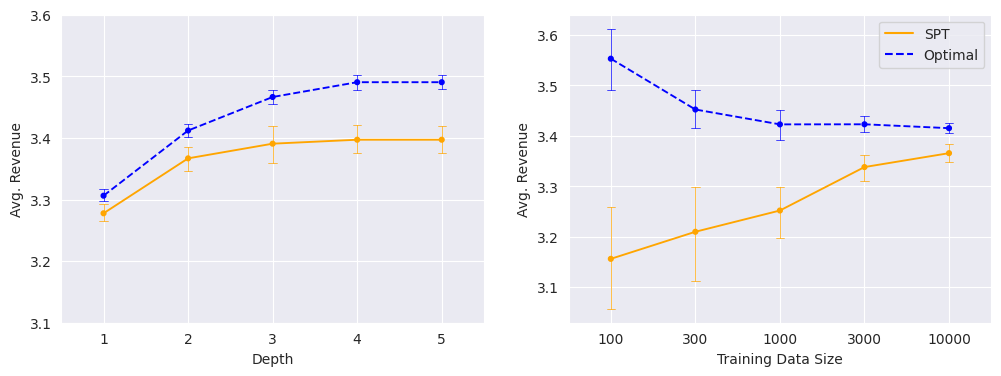

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

# plot SPT results
sns.pointplot(
    data=np.array(spt_results), 
    errorbar=('ci', 90), 
    color='orange',
    linestyles='-',
    capsize=.1,
    scale=0.5,
    errwidth=0.5,
    ax=ax[0]
)
# plot optimal results
sns.pointplot(
    data=np.array(opt_results), 
    errorbar=('ci', 90), 
    color='blue',
    linestyles='--',
    capsize=.1,
    scale=0.5,
    errwidth=0.5,
    ax=ax[0]
)

# plot SPT results
sns.pointplot(
    data=np.array(spt_results2).transpose(), 
    errorbar=('ci', 90), 
    color='orange',
    linestyles='-',
    capsize=.1,
    scale=0.5,
    errwidth=0.5,
    ax=ax[1]
)

# plot optimal results
sns.pointplot(
    data=np.array(opt_results2).transpose(), 
    errorbar=('ci', 90), 
    color='blue',
    linestyles='--',
    capsize=.1,
    scale=0.5,
    errwidth=0.5,
    ax=ax[1]
)

print(np.array(spt_results).mean(axis=0))
print(np.array(opt_results).mean(axis=0))

# format plot
from matplotlib.lines import Line2D

a = Line2D([], [], color='orange', label='SPT')
b = Line2D([], [], color='blue', label='Optimal', linestyle='--')
plt.legend(handles=[a, b])

ax[0].set_ylim(3.1, 3.6)
ax[0].set_xticks(ticks=range(5), labels=[1, 2, 3, 4, 5])
ax[0].set_xlabel("Depth")
ax[0].set_ylabel("Avg. Revenue")
ax[0].grid(True) 

ax[1].grid(True)
ax[1].set_xticks(ticks=range(5), labels=[100, 300, 1000, 3000, 10000])
ax[1].set_xlabel('Training Data Size')
ax[1].set_ylabel('Avg. Revenue')

from google.colab import files
plt.savefig("dataset4_spt.png")
files.download("dataset4_spt.png")

plt.show()

# Evaluate all 5 Datasets

In [ ]:
def get_varying_depth_rev(model_id, n_samples, depths=None):
  spt_results = []
  opt_results = []

  # take multiple samples
  for i in tqdm(range(10)):
    # generate dataset
    data = use_model(model_id=model_id, n_samples=n_samples)

    # get covariates, target and price thresholds
    covariates = [x for x in data.columns if x not in ['optimal_price', 'Y']]
    # print("Covariates:", covariates)
    X = data[covariates]
    y = data['Y']
    price_thresh = data['optimal_price']

    # lightGBM
    num_round = 50 
    model = lgb.LGBMClassifier(n_estimators=num_round)

    # fix imbalance over training set only
    model.fit(X, y)

    # evaluate model at various depths
    if depths is None:
      depths = [1, 2, 3, 4, 5]
    eval = EvaluateSPT(X, y, price_thresh)
    # build predictive and ground truth (optimal) trees
    eval.fit_trees(model, max_depth=max(depths))

    spt_revenues = []
    opt_revenues = []
    for depth in depths:
      # get results
      spt_revenue, opt_revenue = eval.evaluateSPT(depth=depth)
      # append results
      spt_revenues.append(spt_revenue)
      opt_revenues.append(opt_revenue)

    # append final results for sample
    spt_results.append(spt_revenues)
    opt_results.append(opt_revenues)

  return spt_results, opt_results

In [ ]:
model_ids = [1, 2, 3, 4, 5, 6]
table_1_spt = []
table_1_opt = []
for model_id in model_ids:
  print("Model " + str(model_id) + "/" + str(len(model_ids)))
  spt_results, opt_results = get_varying_depth_rev(
      model_id=model_id, n_samples=100)
  
  table_1_spt.append(spt_results)
  table_1_opt.append(opt_results)

  0%|          | 0/10 [00:00<?, ?it/s]


KeyError: ignored

# Risk-Averse SPT

In [73]:
import pymc as pm
import arviz as az

In [104]:
# get synthetic data
n_samples = 100
data = use_model(model_id=1, n_samples=100)

# get data
covariates = [x for x in data.columns if x not in ['Y', 'price', 'optimal_price']]
print(covariates)

X = data[covariates].transpose().to_numpy()
y = data['Y']
price = data['price']

X.shape

['X0', 'X1']


(2, 100)

In [105]:
d = 2 # X.shape[0] # dim of covariate space

with pm.Model() as model:
    # prior scale
    theta = pm.InverseGamma("theta", 1, 1)

    # slopes
    alpha = pm.MvNormal("alpha", mu=[0] * d, cov=theta*np.identity(d))
    beta = pm.MvNormal("beta", mu=[0] * d, cov=theta*np.identity(d))

    p_bar = pm.Deterministic(
        "p_bar", 
        pm.math.invlogit(
            pm.math.dot(alpha, X) + pm.math.dot(beta, X) * price
        )
    )

    # compute shape parameters
    # a = pm.Deterministic("a", (( 1 - p_bar) / theta ** 2 - 1 / p_bar) * p_bar ** 2)
    # b = pm.Deterministic("b", a * (1 / p_bar - 1))

    # expected success rate
    A = pm.Binomial("y", observed=y, n=[1] * len(y), p=p_bar)
    trace = pm.sample(draws=1000, tune=2000, target_accept=0.95, return_inferencedata=True)

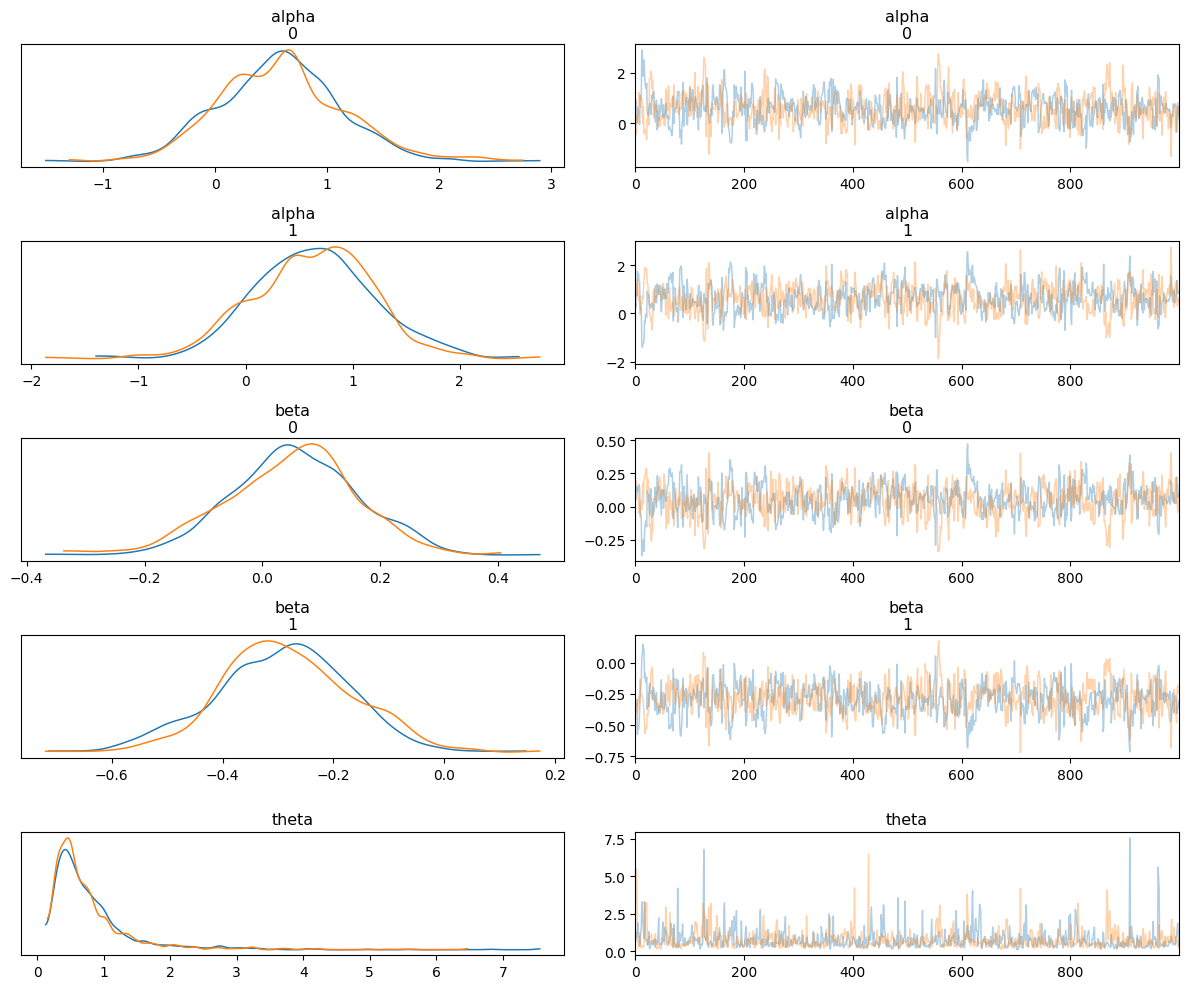

In [106]:
# Check the trace. Looks good!
az.plot_trace(trace, var_names=["alpha", "beta", "theta"], compact=False)

plt.tight_layout()
plt.show()

In [124]:
y_pred = (np.concatenate(
    trace['posterior']['p_bar'],
    axis=0
).mean(axis=0) >= 0.5).astype(int)

print(
    "Accuracy:",
    (y_pred == y).sum() / len(y)
)


Accuracy: 0.73


## Evaluate w.r.t. ground truth function:
Make a function to do all of the evaluation with a few input parameters

In [ ]:
from sklearn.model_selection import train_test_split 

class EvaluateSPT():
  def __init__(self):
    self.teacher_model = None

  # def get_synthetic_data(self, model_id, n_samples):
  #   models = [
  #       model_1(n_samples), 
  #       # model_2(n_samples),
  #       # model_3(n_samples),
  #       # model_4(n_samples),
  #       # model_5(n_samples),
  #       # model_6(n_samples)
  #   ]

  #   return models[model_id]

  def fit_lightGM(self, X, y):
    # split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.5, random_state=49, stratify=y
    )

    # lightGBM
    num_round = 50 
    model = lgb.LGBMClassifier(n_estimators=num_round)

    # fix imbalance over training set only
    model.fit(X_train, y_train)
    self.teacher_model = model

    return X_train, X_test, y_train, y_test

  def get_true_revenue_matrix(self, 
      X, price_thresholds, discrete_prices):
    """
    Get revenue matrix corresponding to ground truth
    generative probability distribution
    discrete_prices: descretized prices
    max_prices: maximum price a customer will pay
    """
    # make empty response matrix
    n, m = X.shape[0], len(discrete_prices)
    revenue_matrix = np.empty((n, m))

    for i, price in enumerate(discrete_prices):
      # construct reponse matrix
      revenue_matrix[:, i] = (price < price_thresholds) * price

    return revenue_matrix

  def get_true_revenue(self, tree1, tree2):
    """
    Get ground truth revenue
    """
    opt_revenue1 = []
    opt_revenue2 = []

    # get descretized prices 
    # should be the same for both trees
    # since both trees were trained on the 
    # same daeta
    prices1 = tree1.prices
    prices2 = tree2.prices

    # get leave nodes for both trees
    leaf_nodes1 = tree1.predict(X_train)
    leaf_nodes2 = tree2.predict(X_train)

    # build to trees, one using the ground truth
    # and the other using teacher revenue estimates
    # evaluate both tree personlized pricing solutions
    # using the ground truth revenue matrix
    for i in range(len(leaf_nodes)):
      # get leaf nodes
      node1 = leaf_nodes1[i]
      node2 = leaf_nodes2[i]
      # get price index assignments 
      k1 = node1['price']
      k2 = node2['price']
      # get price assignments
      assigned_price1 = prices1[k1]
      assigned_price2 = prices2[k2]
      # get leaf datapoints
      S1 = node1['datapoints']
      S2 = node2['datapoints']

      # we can then reference the underlying
      # generative model to determine if the 
      # user purchases or does not
      optimal_rev1 = true_revenue_matrix[S1, k1].sum()
      optimal_rev2 = true_revenue_matrix[S2, k2].sum()

      #total_revenue.append(partition_rev)
      opt_revenue1.append(optimal_rev1)
      opt_revenue2.append(optimal_rev2) 

    # from student
    avg_rev1 = sum(opt_revenue1) / len(X_train)
    # from optimal
    avg_rev2 = sum(opt_revenue2) / len(X_train)

    return avg_rev1, avg_rev2

  def evaluate_tree_depth(
      self, X, y, price_thresholds, max_depths=[1, 2, 3, 4, 5]):
    """
    data: (2d array) data
    max_depths: (list)
    """
    avg_rev1s = []
    avg_rev2s = []
    for max_depth in max_depths:
      # fit teacher model
      X_train, X_test, y_train, y_test = self.fit_lightGM(X, y)
      teacher_model = self.teacher_model

      # fit training data
      tree1 = StudentPrescriptionTree(
          teacher_model=teacher_model, max_depth=max_depth
      )
      tree1.fit(X_train)

      # get ground truth revenue matrix
      true_revenue_matrix = self.get_true_revenue_matrix(
          X_train, price_thresholds, tree1.prices
      )

      # train using ground truth
      tree2 = StudentPrescriptionTree(
          teacher_model=model, max_depth=max_depth
      )
      tree2.fit(
          X_train, 
          revenue_matrix=true_revenue_matrix
      )

      # get model, optimal revenue
      avg_rev1, avg_rev2 = self.get_true_revenue(tree1, tree2)
      # append results
      avg_rev1s.append(avg_rev1)
      avg_rev2s.append(avg_rev2)

    return avg_rev1s, avg_rev2s



In [ ]:
# get synthetic data
data = use_model(model_id=1, n_samples=5000)

# get covariates
covariates = [x for x in data.columns if x not in ['optimal_price', 'Y']]
print(covariates)

# instantiate evaluation class
eval = EvaluateSPT()
avg_rev1s, avg_rev2s = eval.evaluate_tree_depth(
    X=data[covariates],
    y=data['Y'],
    price_thresholds=data['optimal_price'],
    max_depths=[1, 2, 3, 4, 5]
)

['X0', 'X1', 'price']


ValueError: ignored

In [ ]:
parent = tree.root_node['left_child']['right_child']['right_child']
print("Parent Revenue:", parent['revenue'])

left_child = parent['left_child']
right_child = parent['right_child']
children_revenue = left_child['revenue'] + right_child['revenue']
print("Sum of Children Revenue:", children_revenue)

# find out what the hell is going on
S = parent['datapoints']
S1 = left_child['datapoints']
S2 = right_child['datapoints']

# check that S1 + S2 = S
print(
    set(S1.tolist() + S2.tolist()) == set(S)
)

print(len(S1) + len(S2) == len(S))

if children_revenue < parent['revenue']:
  print("Revenue has decreased.")
else:
  print("Revenue has increased.")

Parent Revenue: 774.6708081017775
Sum of Children Revenue: 783.0497155891492
True
True
Revenue has increased.


In [ ]:
# get predicted revenue
test_revenue = tree.predict_revenue(X_test)
optimal_test_revenue = tree.get_optimal_revenue(X_train)
print(test_revenue)
print(optimal_test_revenue)

2.7110929832846016
3.5783138184323224


# SPT Experiment on Synthetic Data

Train lightGBM on dataset 4

In [ ]:
# generate dataset 1
results = use_model(model_id=1, n_samples=5000)

# get data
covariates = [x for x in results.columns if x not in ['optimal_price', 'Y']]
covariates = [x for x in results.columns if x not in ['Y']]
print(covariates)
X = results[covariates]
y = results['Y']

# lightGBM
num_round = 50 
model = lgb.LGBMClassifier(n_estimators=num_round)

# split data in half
from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=49, stratify=y)

# fix imbalance over training set only
model.fit(X_train.drop('optimal_price', axis=1), y_train)
print(model.score(X_test.drop('optimal_price', axis=1), y_test))

['X0', 'X1', 'price', 'optimal_price']
0.7996


In [ ]:
np.flatnonzero((results.optimal_price[0] > tree.prices))

array([0, 1, 2, 3])

In [ ]:
policy = results.optimal_price\
    .apply(lambda x: np.flatnonzero(x > tree.prices))\
    .apply(lambda x: max(x) if x.size > 0 else -1)\
# remove missed sales opptunitites
policy = policy[policy != -1]
# convert indices back to price
policy = policy.apply(lambda x: tree.prices[x])


policy.sum() / 10000

4.21936798196952

In [ ]:
tree.prices

array([3.74130328, 4.06157776, 4.38185223, 4.7021267 , 5.02240117,
       5.34267564, 5.66295012, 5.98322459, 6.30349906])

In [ ]:
from tqdm import tqdm

In [ ]:
# try various tree depths
test_revenue = []
train_revenue = []
max_depths = [1, 2, 3, 4, 5]
for max_depth in tqdm(max_depths):  
  # initialize prescription tree
  tree = StudentPrescriptionTree(teacher_model=model, max_depth=max_depth)
  # fit training data
  tree.fit(X_train)
  try:
    # get personalized tree revenue
    test_revenue.append(
        tree.predict_revenue(X_test)
    )
  except:
    print("Invalid max depth:", max_depth)
    test_revenue.append(np.nan)
  try:
    train_revenue.append(
        tree.predict_revenue(X_train)
    )
  except:
    print("Invalid max depth:", max_depth)
    train_revenue.append(np.nan)
# get results
optimal_test_revenue = optimal_pricing_policy(data=results, tree=tree)

100%|██████████| 5/5 [00:53<00:00, 10.78s/it]

Invalid max depth: 5
Invalid max depth: 5


Optimal Revenue: 4.3201024486673445
Revenue, tree depth = 3: 3.478336318283445


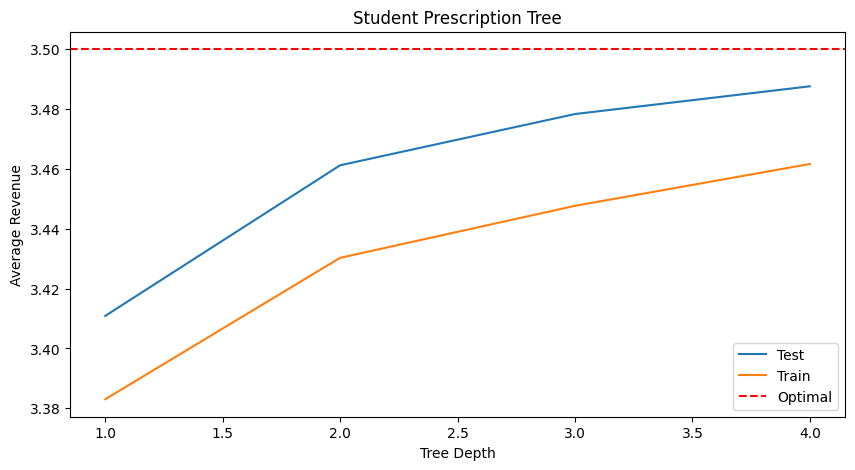

In [ ]:
# make figure
fig = plt.figure(figsize=(10, 5))

# plot results
plt.plot(max_depths, test_revenue)
plt.plot(max_depths, train_revenue)
# plt.plot(max_depths, train_revenue)
plt.axhline(y=3.5, color='r', linestyle='--')
print(
    "Optimal Revenue:",
    optimal_test_revenue
)

print(
    "Revenue, tree depth = 3:",
    test_revenue[2]
)

plt.title("Student Prescription Tree")
plt.xlabel("Tree Depth")
plt.ylabel("Average Revenue")
plt.legend(['Test', 'Train', 'Optimal'])

plt.show()

In [ ]:
from tqdm import tqdm

def experiment_tree_depths(model_id):
  test_revenues = []
  train_revenues = []
  optimal_test_revenues = []
  for _ in tqdm(range(10)):
    # generate dataset 1
    results = use_model(model_id=model_id, n_samples=5000)

    # get data
    covariates = [
        x for x in results.columns if x not in ['optimal_price', 'Y']
    ]
    X = results[covariates]
    y = results['Y']

    # lightGBM
    num_round = 50 
    model = lgb.LGBMClassifier(n_estimators=num_round)

    # split data in half
    from sklearn.model_selection import train_test_split 
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.5, random_state=49, stratify=y
    )

    # fix imbalance over training set only
    model.fit(X_train, y_train)

    # try various tree depths
    test_revenue = []
    train_revenue = []
    max_depths = [1, 2, 3, 4, 5]
    for max_depth in max_depths:  
      # initialize prescription tree
      tree = StudentPrescriptionTree(teacher_model=model, max_depth=max_depth)
      # fit training data
      tree.fit(X_train)
      try:
        # get personalized tree revenue
        test_revenue.append(
            tree.predict_revenue(X_test)
          )
      except:
        print("Invalid max depth:", max_depth)
        test_revenue.append(np.nan)

      try:
        train_revenue.append(
          tree.predict_revenue(X_train)
        )
      except:
        print("Invalid max depth:", max_depth)
        train_revenue.append(np.nan)
      
    # get results
    optimal_test_revenue = tree.get_optimal_revenue(X_test)

    # append results
    test_revenues.append(test_revenue)
    train_revenues.append(train_revenue)
    optimal_test_revenues.append(optimal_test_revenue)

  return test_revenues, train_revenues, optimal_test_revenues

In [ ]:
test_revenues, train_revenues, optimal_test_revenues = experiment_tree_depths(model_id=4)

 10%|█         | 1/10 [00:20<03:07, 20.84s/it]

Invalid max depth: 5
Invalid max depth: 5


 50%|█████     | 5/10 [01:30<01:30, 18.01s/it]

Invalid max depth: 5
Invalid max depth: 5


 60%|██████    | 6/10 [01:52<01:16, 19.22s/it]

Invalid max depth: 5
Invalid max depth: 5


 80%|████████  | 8/10 [02:30<00:38, 19.04s/it]

Invalid max depth: 5
Invalid max depth: 5


100%|██████████| 10/10 [03:08<00:00, 18.83s/it]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

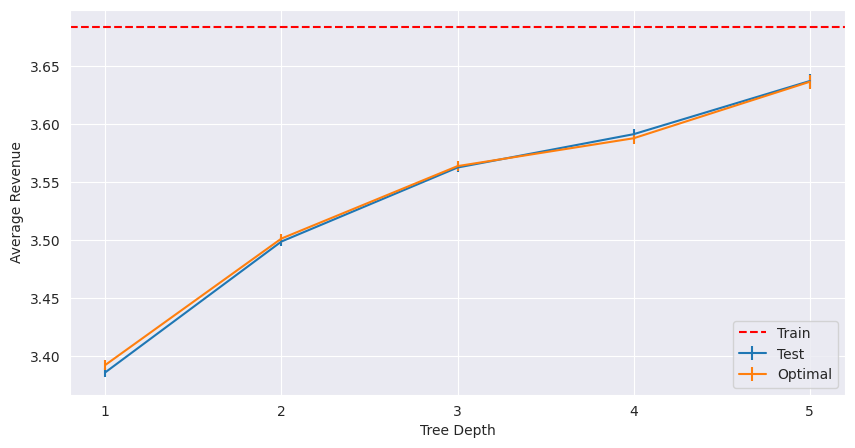

In [ ]:
# make figure
sns.set_style("darkgrid")
fig = plt.figure(figsize=(10, 5))

# average revenue over trials
avg_test_rev = [np.mean([x[i] for x in test_revenues if ~np.isnan(x[i])]) for i in range(5)]
avg_train_rev = [np.mean([x[i] for x in train_revenues if ~np.isnan(x[i])]) for i in range(5)]
# 95% confidence interval - normal
yerr = [
    2 * 1.96 * np.var([x[i] / np.sqrt(10) for x in test_revenues if ~np.isnan(x[i])])  
    for i in range(5)
]

# plt.plot([x for x in range(5)], [np.mean([x[i] for x in train_revenues if ~np.isnan(x[i])]) for i in range(5)])
plt.axhline(y=np.mean(optimal_test_revenues), color='r', linestyle='--')

#plot test
plt.errorbar(
    [x for x in range(5)], 
    avg_train_rev,
    yerr=yerr
)

# plot train
plt.errorbar(
    [x for x in range(5)], 
    avg_test_rev,
    yerr=yerr
)

# plt.title("Student Prescription Tree")
plt.xlabel("Tree Depth")
plt.ylabel("Average Revenue")
plt.legend(['Train', 'Test', 'Optimal'])

plt.xticks([x for x in range(5)], labels=[x + 1 for x in range(5)])

from google.colab import files
plt.savefig("dataset4_spt.png")
files.download("dataset4_spt.png")

plt.show()

In [ ]:
print(np.nan_to_num(np.nan, 0))
print(np.nan_to_num(3, 0))

0.0
3


# Causal Trees

In [ ]:
$ conda activate R_env

SyntaxError: invalid syntax (<ipython-input-165-ee9caf18a9ae>, line 1)

In [ ]:
%load_ext rpy2.ipython 

ModuleNotFoundError: No module named 'rpy2'

In [ ]:
%%R -i df -w 5 -h 5 --units in -r 200
# import df from global environment
# make default figure size 5 by 5 inches with 200 dpi resolution

install.packages("ggplot2", repos='http://cran.us.r-project.org', quiet=TRUE)
library(ggplot2)
ggplot(df, aes(x=cups_of_coffee, y=productivity)) + geom_line()